# The _Aedes aegypti_ Ejaculotome
## Proteomics and RNAseq analysis pipeline
### Degner _et al_.

Several data sources were generated for this project, first, proteomic data was obtained ....

In addition, several RNAseq runs of the male accessory glands (before and after mating) and testes were obtained using 3'RNAseq.

We also include analysis of publicly avaialable RNAseq data.

The analysis workflow (read mapping, transcript assembly, and abundance estimation) is available through GitHub (***link Snakemake GitHub page here***).

### Load the required packages and raw data files:

Load the reuired R packages for analyses/plotting:

In [1]:
req_packages = c("ballgown", "Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "dplyr","DESeq", "edgeR", "genefilter", "ggplot2", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", 
                 "heatmap3", "imager", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr", "tidyr",
                 "VennDiagram", "wesanderson")

invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

The Cowplot package changes the default themes of ggplot2. Set the default theme like so:

In [2]:
theme_set(theme_gray())

The VennDiagram package produces log files for each plot. We can disable that like so:

In [3]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

In addition, several custom plotting and annotation functions are available in the `Functions2.R` file, so load as source:

In [4]:
source("R_functions.R")

Now load the raw count matrices for genes and transcripts. Note that the gene/transcript IDs are designated by the StringTie program, and either contain the "MSTRG" prefix (unique splice/exon relative to annotation features) or the "AAEL" prefix (perfect match to annotated feature)

In [5]:
geneCounts = read.csv(file = "expression_data/gene_counts.csv", header = T, sep = ",", row.names = 1)
transcriptCounts = read.csv(file = "expression_data/transcript_counts.csv", header = T, sep = ",", row.names = 1)

There're several anotation files that were generated through Trinotate, downloaded from VectorBase, or produced along with the proteomics run. We'll use these files throughout the analysis. 

First, the gene features file has the coordinates, StringTie gene/transcript IDs and VectorBase gene/transcript names where avilable:

In [6]:
gene.features = read.table("annotation/features.txt", header = T)

We'll create a subset of the gene features that includes only VectorBase annotated features:

In [7]:
annot.gene.features = subset(gene.features, ref_gene_id != "NA")

The original NCBI GenBank annotation of the AegL5 genome included additional protein descriptions as well:

In [8]:
genbank_proteins = read.csv("annotation/Protein_annotation.txt", header =T, sep = "\t")

The gene/transcript IDs in `genbank_proteins` are those designated by NCBI ("LOC" prefix). We generated a file to match these RefSeq IDs with the latest VectorBae IDs. If a RefSeq record does not exist for a given VectorBase ID, that typically means the VectorBase feature is not a protein:

In [9]:
RefSeq_ids = read.csv("annotation/VB.L5.transcript_gene_RefSeq.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

A summary of gene descriptions and gene names (wherever available) can be found in the VectorBase annotation GTF. We've extracted that information from the GTF in the form of a table:

In [10]:
AaegL5_annotation = read.csv("annotation/AaegL5.gene.annotation.txt", header = T, sep = "\t")

Our custom annotation is generated using the Trinotate workflow (***link Snakemake GitHub page here***), which is a massive file with lots of annotation information. The gene descriptinos here come from a BlastX and BlastP search against the SwissProt database, but the raw entry in the Trinotate file is a bit combursome. We extract the relevant descriptions and append them as the last two columns of the file:

In [11]:
trinotate = read.csv("annotation/Trinotate_report.xls_with_description_columns.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

The Trinotate pipeline produces extensive Gene Ontology (GO) terms associated with each gene. We can use this data for GO enrichment analysis later on.

In [12]:
GO_info = read.csv("annotation/Trinotate_report.xls.gene_ontology", header=F, row.names=1, sep = "\t", stringsAsFactors=F)

VectorBase also provides more concise GO information, but only ~10K genes have such annotations. Might be useful later:

In [13]:
VB_GO_info = read.csv("annotation/VB_GO_info.txt", header = F, sep = "\t")
VB_GO_info = VB_GO_info[!duplicated(VB_GO_info$V1),]
rownames(VB_GO_info) = VB_GO_info$V1
VB_GO_info = subset(VB_GO_info, select = "V2")

For the GO enrichment analysis, we'll need gene lengths. We've extracted transcript lengths from the GTF file, and can load those first

In [14]:
trans_lengths = read.csv("annotation/transcript_lengths.txt", header = T, sep = " ")

We can obtain gene lengths for each gene by capturing the length of the longest transcript. One way to do that is as follows:

In [15]:
# Merge transcript length file with gene features file:
tmpMrge = merge(trans_lengths, gene.features)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
gene_lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
# remove un-needed intermediate objects
rm(tmpMrge)

So far we have several types of gene IDs, several sources of gene descriptions etc. For convenience, we might want to create a unified features object that can be incorporated into the edgeR DE objects. Here's one format for this:

In [16]:
# Select only gene IDs from the gene.features object, and make unique:
gene_id_and_ref_gene_id = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
# Select only the gene ID and protein description from the RefSeq Ids object
tmpRef = unique(subset(RefSeq_ids, select = c("gene_ID", "RefSeq_protein_name")))

# Now merge those two objects, then sequentially merge the GenBank object and the VectorBase annotation:
gene_id_and_ref_gene_id = merge(tmpRef, gene_id_and_ref_gene_id, by.x="gene_ID", by.y="ref_gene_id", all = TRUE)
gene_id_and_ref_gene_id = merge(gene_id_and_ref_gene_id, genbank_proteins, by.x="RefSeq_protein_name", by.y="protein_name", all = TRUE)
merged_gene_features = merge(gene_id_and_ref_gene_id, AaegL5_annotation, by.x="gene_ID", by.y="gene_id", all = TRUE)

# Rename the columns to something descriptive:
colnames(merged_gene_features) = c("gene_ID", "RefSeq_protein", "mstrg_ID", "transcript_ID", "loc_ID",    "GenBank_description", "gene_name", "VB_description")

# We can choose a subset of these columns for the active fatures table (The GenBank description seems the most conplete):
geneFeatures = unique(subset(merged_gene_features, select = c("mstrg_ID", "gene_ID", "loc_ID", "gene_name", "GenBank_description")))

We also ran an extensive OrthoDB search against several species:

In [17]:
orthoDB = read.csv(file = "proteomics/ortho_aedes1_ids.txt", header = T, sep = "\t")

Some of these species have excellent annotations, which we can utilize later on. For instance, here's the _Anopheles gambiae_ annotation from its ENSMBL GTF file:

In [18]:
AgamP4_annotation = read.csv("annotation/other_species/AgamP4.protein.annotation.txt", header = T, sep = "\t")

From Alfonso-Parra _et al._ (2016) we have the list of transferred male mRNAs at 0hpm. We'll load those here:

In [19]:
tmRNA = read.csv("annotation/Alfonso_Parra_transfered_mRNA.list", header = F)
tmRNA.df = data.frame(gene_ID = tmRNA$V1, mRNA_transfer = "yes")

Finally, we'll input the sample information and add sample features based on sample names:

In [20]:
# Load the file and rename the columns:
sampleData = read.table("annotation/sample_replicate_map.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]
colnames(sampleData) = c("Sample", "Replicate")

## Add a tissue column
sampleData$Tissue = ifelse(grepl("MAG", sampleData$Sample, ignore.case = F), "MAG", ifelse(grepl("TS", sampleData$Sample, ignore.case = F), "Testes", ifelse(grepl("testes", sampleData$Sample, ignore.case = F), "Testes", ifelse(grepl("RT", sampleData$Sample, ignore.case = F), "fRT", ifelse(grepl("CR", sampleData$Sample, ignore.case = F), "carcass", "Sperm")))))

## Add a source column
sampleData$Source = ifelse(grepl("RT", sampleData$Sample, ignore.case = F), "Alfonso-Parra", ifelse(grepl("MAG", sampleData$Sample, ignore.case = F), "Degner", ifelse(grepl("testes", sampleData$Sample, ignore.case = F), "Degner", ifelse(grepl("Ma_CR", sampleData$Sample, ignore.case = F), "Akbari", ifelse(grepl("Ma_TS", sampleData$Sample, ignore.case = F), "Akbari", "Sutton")))))

### Processing the expression data:

First, we have to filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 5 CPM in at least 4 samples:

In [21]:
gene.CPM <- cpm(geneCounts)
thresh <- gene.CPM > 5
keep <- rowSums(thresh) >= 4
counts.keep <- geneCounts[keep,]
dim(counts.keep)

[1] 12340    26

Using the threshold above applies well for Ethan's data (note the 3' read difference with other samples). If we filter low expression data at 10 CPM, that's equal to an average of 150 reads/gene for Ethan's data.

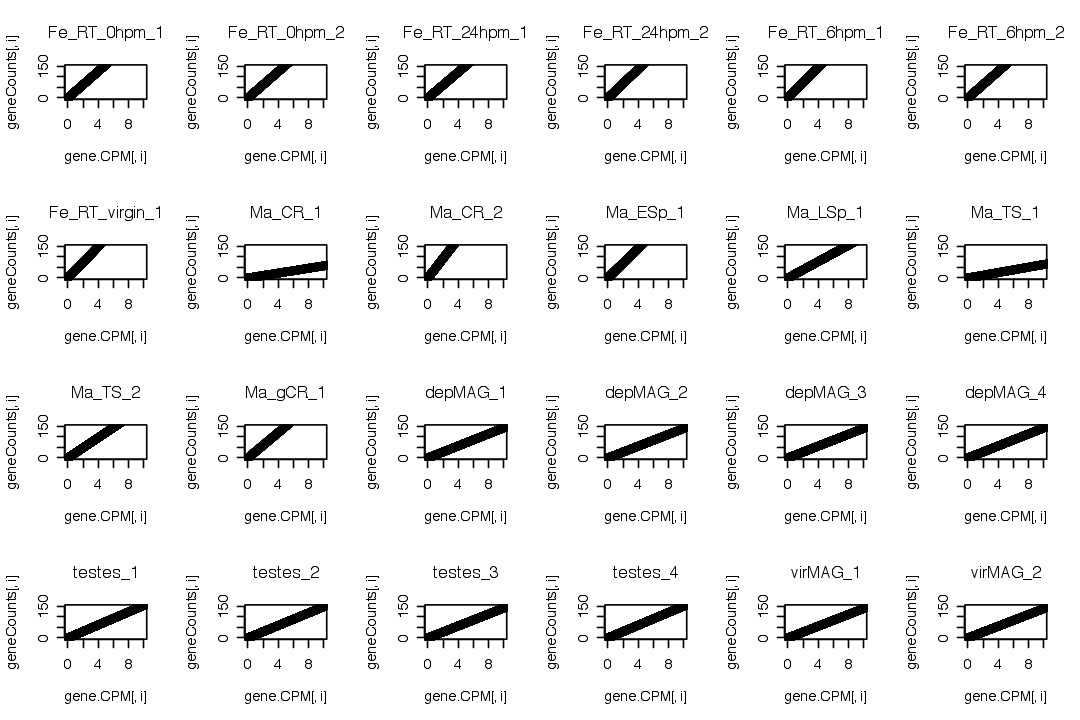

In [22]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(4,6))
for(i in seq(from=1, to=24, by=1)){
  plot(gene.CPM[,i],geneCounts[,i], xlim=c(0,10), ylim=c(0,150))
  title(colnames(gene.CPM)[i])
}

To obtain a TPM matrix of the combined data, we'll need to separate the 3'RNAseq data (Ethan's) from the rest, obtain TPM normalizations separately, then combine the matrices. First, we'll do Ethan's data (pick any number for gene length. Here I chose the average gene length of 2922):

In [23]:
ethan.countsMatrix = subset(geneCounts, select=c("depMAG_1", "depMAG_2", "depMAG_3", "depMAG_4", "testes_1", "testes_2", "testes_3", "testes_4", "virMAG_1", "virMAG_2", "virMAG_3", "virMAG_4"))
ethan.geneTPM <- apply(ethan.countsMatrix, 2, function(x) tpm(x, 2922))
ethan.geneTPM = as.data.frame(ethan.geneTPM)

Now we'll TPM normalize the remainder. For that we'll need to match the gene length data frame with the counts matrix data frame:

In [24]:
rest.countsMatrix = subset(geneCounts, select=c("Fe_RT_0hpm_1", "Fe_RT_0hpm_2", "Fe_RT_24hpm_1", "Fe_RT_24hpm_2", "Fe_RT_6hpm_1", "Fe_RT_6hpm_2", "Fe_RT_virgin_1", "Ma_CR_1", "Ma_CR_2", "Ma_ESp_1", "Ma_LSp_1", "Ma_TS_1", "Ma_TS_2", "Ma_gCR_1"))
rest.geneTPM <- apply(rest.countsMatrix, 2, function(x) tpm(x, gene_lengths$length))
rest.geneTPM = as.data.frame(rest.geneTPM)

Now we can combine both TPM matrices:

In [25]:
geneTPM = cbind(rest.geneTPM, ethan.geneTPM)

We'll need to reshape the TPM matrix to calculate means and for convenient heatmap and gene plotting later:

In [26]:
tmp.tpmMatrix<-geneTPM
colnames(tmp.tpmMatrix) <- sampleData$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "sample", "TPM")

tmp.tpmMatrix.m$Tissue = ifelse(grepl("MAG", tmp.tpmMatrix.m$sample, ignore.case = F), "MAG", ifelse(grepl("TS", tmp.tpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("testes", tmp.tpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("RT", tmp.tpmMatrix.m$sample, ignore.case = F), "fRT", ifelse(grepl("CR", tmp.tpmMatrix.m$sample, ignore.case = F), "carcass", "Sperm")))))

tmp.tpmMatrix.m$Source = ifelse(grepl("RT", tmp.tpmMatrix.m$sample, ignore.case = F), "Alfonso-Parra", ifelse(grepl("MAG", tmp.tpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("testes", tmp.tpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("Ma_CR", tmp.tpmMatrix.m$sample, ignore.case = F), "Akbari", ifelse(grepl("Ma_TS", tmp.tpmMatrix.m$sample, ignore.case = F), "Akbari", "Sutton")))))

TPM.table = tmp.tpmMatrix.m

Now we'll calculate the TPM mean and standard deviation/error for each gene across samples (warning: this will take a few minutes):

In [27]:
# tmp.tpmMatrix.m.c = summarySE(TPM.table, measurevar = "TPM", groupvars = c("gene_id", "sample", "Tissue", "Source"))

#### The above step is cumbersome. We'll save a file and read it in as an object.
# write.table(x = tmp.tpmMatrix.m.c, file = "expression_data/tmp.tpmMatrix.m.c.txt", quote = F, sep = "\t", row.names = F)

TPMse = read.table(file = "expression_data/tmp.tpmMatrix.m.c.txt", header = T, sep = "\t")

We can use the TPM means to make a mean TPM matrix for heatmaps:

In [28]:
tmpTPM.Mat <- cast(TPMse, gene_id~sample, value = "TPM")
meanTPMmatrix <- tmpTPM.Mat[,-1]
rownames(meanTPMmatrix) <- tmpTPM.Mat[,1]

We can feed a subset of the annotation data to the DGElist object in edgeR. We'll create that subset like so (mstrg_IDs must match the gene IDs in the counts matrix, and can't be duplicated):

In [29]:
annots = unique(subset(geneFeatures, select=c("mstrg_ID", "gene_ID", "gene_name", "GenBank_description")))
annots = annots[!duplicated(annots$mstrg_ID),]

We'll set the factor level for samples in the `TPMse` dataframe so that samples are ordered the way we want:

In [30]:
TPMse$sample = factor(TPMse$sample, levels = c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "Ma_CR", "Ma_TS", "Ma_gCR", "Ma_ESp", "Ma_LSp", "testes", "virMAG", "depMAG"))

TPM.table$sample = factor(TPM.table$sample, levels = c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "Ma_CR", "Ma_TS", "Ma_gCR", "Ma_ESp", "Ma_LSp", "testes", "virMAG", "depMAG"))

##### Comprehensive RNAseq dataset:

As part of a separate resource we have generated an extensive expression atlas for _Ae. aegypti_, which we can also use in this study. A function for plotting individual gene express data is included in the functions file that we loaded above. The expression data can be loaded here:

In [31]:
compRNAseq = read.csv("expression_data/aegypti_comp_RNAseq_data_v2.txt", header = T, sep = "\t")

An example of plotting a given gene's expression is given below:

In [32]:
# options(repr.plot.width = 10, repr.plot.height = 13)
# suppressWarnings(compGeneBarplot("AAEL000326"))

## Differential expression: tissue-biased reproductive genes:

Here we'll define several classes of genes based on their tissue-biased expression pattern. Those will include: (1) testes-biased geens, (2) MAG-biased genes, and (3) female RT-biased genes. Because there are several ways to specify tissue bias, we'll use three classifications for each tissue: (1) extremely biased (≥4-fold difference in expression relative to other tissue, and FDR ≤ 0.01), (2) DE biased (≥2-fold, FDR ≤ 0.05), and (3) biased (≥1-fold, FDR ≤ 0.05). We'll also define a class of genes that show detectable expression in a given tissue, regardless of expression in other tissues (TPM > 1). 

The design matrix will include all samples in our expression matrix, but we'll only define the above gene classes for the virMAG, Fe_RT_virgin, and testes samples. First we'll determine the grouping of samples and set-up the model matrix:

In [33]:
groups = factor(sampleData$Sample)
design = model.matrix( ~ 0 + groups)
colnames(design) <- levels(groups)
rownames(design) <- sampleData$Replicate

Now we'll create the edgeR DGE object with these groupings and fit the generalized linear model:

In [34]:
dgeList <- DGEList(counts = counts.keep, group = groups)
dgeList <- calcNormFactors(dgeList)
dgeList <- estimateCommonDisp(dgeList)
dgeList <- estimateTagwiseDisp(dgeList)
dgeList_fit <- glmFit(dgeList, design)

Now we can add the subsetted annotation information we created previously to the fit object. We check that there're a one to one match between the fit object's rownames (genes) and the annotation file's gene IDs:

In [35]:
# Extract annotation for genes in the fit object
ann = subset(annots, mstrg_ID %in% rownames(dgeList_fit))
# convert factors to characters
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann = ann[match(rownames(dgeList_fit), ann$mstrg_ID),]
# convert factors to characters, again
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann) = c ("GeneID", "VB_ID", "gene_name","Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann$GeneID==rownames(dgeList_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList_fit$genes = ann


 TRUE 
12340 

We can take a quick look at the basic variability metrics by examining the tagwise dispersion:

In [36]:
summary(dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04714 0.07948 0.13290 0.22240 0.24370 6.27200 

We can take a closer look at the DE metrics and whether overall variability in the counts is suitable by plotting the BCV, looking at the mean-variance trend and QQplot. We'll also make a boxplot of normalized counts:

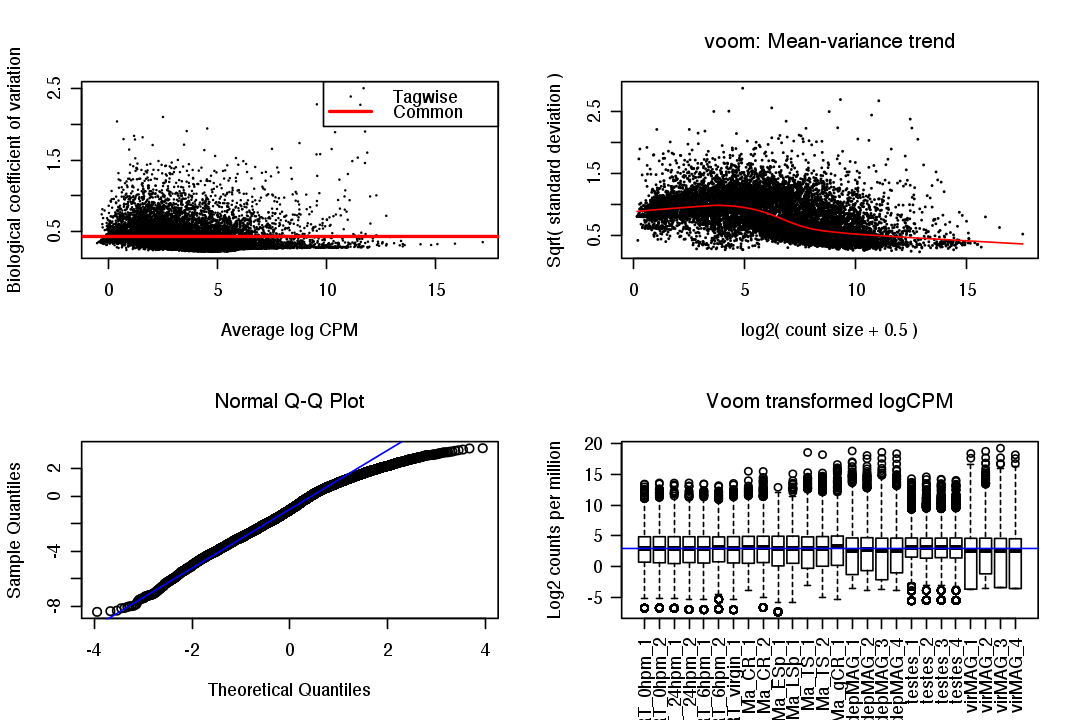

In [37]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
voomC = voom(dgeList, design, plot=TRUE)
# QQ-plot
g <- gof(dgeList_fit)
z <- zscoreGamma(g$gof.statistics,shape=g$df/2,scale=2)
qqnorm(z); qqline(z, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voomC$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voomC$E),col="blue")

An interactive MDS plot gives an idea of how replicates/samples are grouping:

In [38]:
glMDSPlot(dgeList, groups = dgeList$samples$group, labels = sampleData$Tissue)

... or a static plot works too:

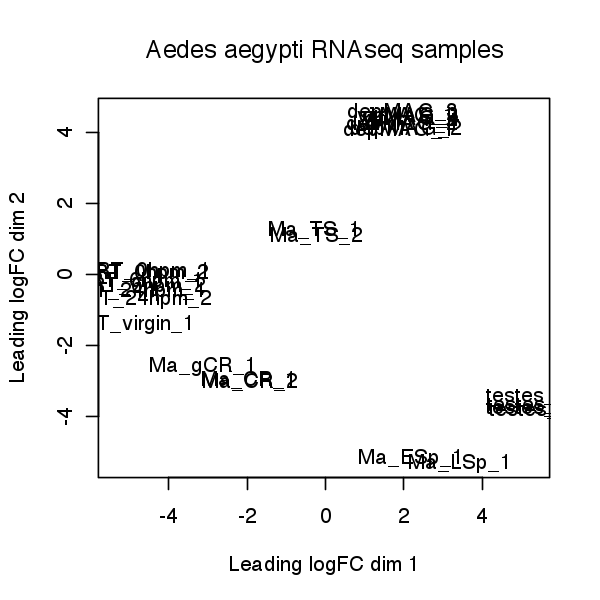

In [39]:
options(repr.plot.width = 5, repr.plot.height = 5)
plotMDS(dgeList)
title("Aedes aegypti RNAseq samples")

A heatmap of sample correlations is also useful

for plotting:: min.raw: 0.0808748122648092 max.raw: 1


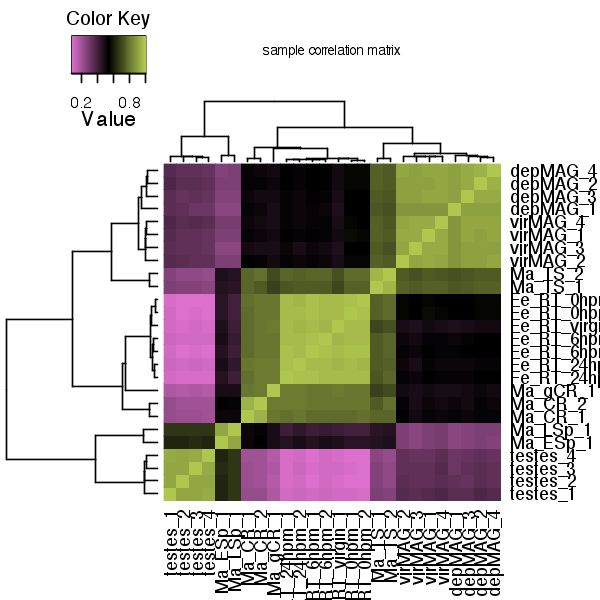

In [40]:
data = log2(counts.keep+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 5, repr.plot.height = 5)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Now we're ready to define the contrasts. For the three samples we'd like to define gene classes for, the following contrasts can be defined:

In [41]:
testes.v.rest <- makeContrasts(testes.v.gCR=testes-Ma_gCR,
                                 testes.v.MAG=testes-virMAG,
                                 testes.vs.fRT=testes-Fe_RT_virgin,
                                 levels=design)
MAG.v.rest <- makeContrasts(MAG.v.gCR=virMAG-Ma_gCR,
                                 MAG.v.testes=virMAG-testes,
                                 MAG.vs.fRT=virMAG-Fe_RT_virgin,
                                 levels=design)
fRT.v.rest <- makeContrasts(fRT.v.Ma_CR=Fe_RT_virgin-Ma_CR,
                            fRT.v.testes=Fe_RT_virgin-testes,
                            fRT.v.MAG=Fe_RT_virgin-virMAG,
                            levels=design)

## Defining tissue-biased classes of genes:

To identify those classes of genes, we'll perform a likelihood ratio test on the GLM fit object that compares the testes sample to the gonadectomized carcass sample, the MAG sample, and the virgin female RT sample. We'll then define the three classes of testes-biased genes and those that show detectable expression in the testes:

##### Classes of testes genes:

In [42]:
# LRT tests
lrt.testes <- glmLRT(dgeList_fit, contrast = testes.v.rest)

# Extract the DE data
lrt.testes.tTags <- topTags(lrt.testes, n = NULL)

# Make a table of DE stats
lrt.testes.tTags.table <- lrt.testes.tTags$table

# Define the first class: Extremely biased
testes.extreme.list <- subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 2 & logFC.testes.v.MAG > 2 & logFC.testes.vs.fRT > 2 & FDR<0.05)$GeneID

# Define the second class: DE biased
testes.DEup.list <- subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 1 & logFC.testes.v.MAG > 1 & logFC.testes.vs.fRT > 1 & FDR<0.05)$GeneID

# Define the third class: biased
testes.up.list <- subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 0 & logFC.testes.v.MAG > 0 & logFC.testes.vs.fRT > 0 & FDR<0.05)$GeneID

# Finally, we'll make a list of all the genes that show detectable testes expression (TPM > 1):
testes.expressed.list <- rownames(subset(meanTPMmatrix, testes > 1))


# For each of these we can pull out those that are previously annotated
testes.extreme.list.CDS = unique(subset(gene.features, gene_id %in% testes.extreme.list & ref_gene_id != "NA")$gene_id)
testes.DEup.list.CDS = unique(subset(gene.features, gene_id %in% testes.DEup.list & ref_gene_id != "NA")$gene_id)
testes.up.list.CDS = unique(subset(gene.features, gene_id %in% testes.up.list & ref_gene_id != "NA")$gene_id)
testes.expressed.list.CDS = unique(subset(gene.features, gene_id %in% testes.expressed.list & ref_gene_id != "NA")$gene_id)


paste("The number of gene transcripts with >4-fold DE testis-biased expression is: ", length(testes.extreme.list), ", of which ", length(testes.extreme.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >2-fold DE testis-biased expression is: ", length(testes.DEup.list), ", of which ", length(testes.DEup.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >1-fold DE testis-biased expression is: ", length(testes.up.list), ", of which ", length(testes.up.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with detectable testis expression is: ", length(testes.expressed.list), ", of which ", length(testes.expressed.list.CDS), " are annotated. ", sep="")

[1] "The number of gene transcripts with >4-fold DE testis-biased expression is: 2304, of which 1260 are annotated. "

[1] "The number of gene transcripts with >2-fold DE testis-biased expression is: 3013, of which 1928 are annotated. "

[1] "The number of gene transcripts with >1-fold DE testis-biased expression is: 4001, of which 2863 are annotated. "

[1] "The number of gene transcripts with detectable testis expression is: 17537, of which 10861 are annotated. "

We'll make a table summarizing the above lists (the fold bias refers to the fold change relative to other tissue samples used in the edgeR DE analysis above):

In [43]:
testes.4fold.df = data.frame(mstrg_ID = testes.extreme.list.CDS, testes_fourFold_bias = "yes", stringsAsFactors = FALSE)
testes.2fold.df = data.frame(mstrg_ID = testes.DEup.list.CDS, testes_twoFold_bias = "yes", stringsAsFactors = FALSE)
testes.1fold.df = data.frame(mstrg_ID = testes.up.list.CDS, testes_oneFold_bias = "yes", stringsAsFactors = FALSE)
testes.expressed.df = data.frame(mstrg_ID = testes.expressed.list.CDS, testes_expressed = "yes", stringsAsFactors = FALSE)

merge1st = (merge(testes.expressed.df, testes.1fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))
merge2nd = (merge(merge1st, testes.2fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))
testes.expression.status = (merge(merge2nd, testes.4fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))

testes.expression.status <- sapply(testes.expression.status, as.character)
testes.expression.status[is.na(testes.expression.status)] <- "no"
testes.expression.status <- as.data.frame(testes.expression.status, stringsAsFactors = FALSE)

##### Classes of accessory gland genes:

In [44]:
# LRT tests
lrt.MAG <- glmLRT(dgeList_fit, contrast = MAG.v.rest)

# Extract the DE data
lrt.MAG.tTags <- topTags(lrt.MAG, n = NULL)

# Make a table of DE stats
lrt.MAG.tTags.table <- lrt.MAG.tTags$table

# Define the first class: Extremely biased
MAG.extreme.list <- subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 2 & logFC.MAG.v.testes > 2 & logFC.MAG.vs.fRT > 2 & FDR<0.05)$GeneID

# Define the second class: DE biased
MAG.DEup.list <- subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 1 & logFC.MAG.v.testes > 1 & logFC.MAG.vs.fRT > 1 & FDR<0.05)$GeneID

# Define the third class: biased
MAG.up.list <- subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 0 & logFC.MAG.v.testes > 0 & logFC.MAG.vs.fRT > 0 & FDR<0.05)$GeneID

# Finally, we'll make a list of all the genes that show detectable MAG expression (TPM > 1):
MAG.expressed.list <- rownames(subset(meanTPMmatrix, virMAG > 1))


# For each of these we can pull out those that are previously annotated
MAG.extreme.list.CDS = unique(subset(gene.features, gene_id %in% MAG.extreme.list & ref_gene_id != "NA")$gene_id)
MAG.DEup.list.CDS = unique(subset(gene.features, gene_id %in% MAG.DEup.list & ref_gene_id != "NA")$gene_id)
MAG.up.list.CDS = unique(subset(gene.features, gene_id %in% MAG.up.list & ref_gene_id != "NA")$gene_id)
MAG.expressed.list.CDS = unique(subset(gene.features, gene_id %in% MAG.expressed.list & ref_gene_id != "NA")$gene_id)


    paste("The number of gene transcripts with >4-fold DE MAG-biased expression is: ", length(MAG.extreme.list), ", of which ", length(MAG.extreme.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >2-fold DE MAG-biased expression is: ", length(MAG.DEup.list), ", of which ", length(MAG.DEup.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >1-fold DE MAG-biased expression is: ", length(MAG.up.list), ", of which ", length(MAG.up.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with detectable MAG expression is: ", length(MAG.expressed.list), ", of which ", length(MAG.expressed.list.CDS), " are annotated. ", sep="")

[1] "The number of gene transcripts with >4-fold DE MAG-biased expression is: 706, of which 299 are annotated. "

[1] "The number of gene transcripts with >2-fold DE MAG-biased expression is: 1237, of which 711 are annotated. "

[1] "The number of gene transcripts with >1-fold DE MAG-biased expression is: 2142, of which 1485 are annotated. "

[1] "The number of gene transcripts with detectable MAG expression is: 9276, of which 7035 are annotated. "

In [45]:
MAG.4fold.df = data.frame(mstrg_ID = MAG.extreme.list.CDS, MAG_fourFold_bias = "yes", stringsAsFactors = FALSE)
MAG.2fold.df = data.frame(mstrg_ID = MAG.DEup.list.CDS, MAG_twoFold_bias = "yes", stringsAsFactors = FALSE)
MAG.1fold.df = data.frame(mstrg_ID = MAG.up.list.CDS, MAG_oneFold_bias = "yes", stringsAsFactors = FALSE)
MAG.expressed.df = data.frame(mstrg_ID = MAG.expressed.list.CDS, MAG_expressed = "yes", stringsAsFactors = FALSE)

merge1st = (merge(MAG.expressed.df, MAG.1fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))
merge2nd = (merge(merge1st, MAG.2fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))
MAG.expression.status = (merge(merge2nd, MAG.4fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))

MAG.expression.status <- sapply(MAG.expression.status, as.character)
MAG.expression.status[is.na(MAG.expression.status)] <- "no"
MAG.expression.status <- as.data.frame(MAG.expression.status, stringsAsFactors = FALSE)

We'll combine the testes and MAG expression status tables to merge with the ejaculotome data later:

In [46]:
expression.status = merge(MAG.expression.status, testes.expression.status, all = T)
expression.status[is.na(expression.status)] <- "no"
expression.status <- as.data.frame(expression.status)

##### Classes of female reproductive tract genes:

In [47]:
# LRT tests
lrt.fRT <- glmLRT(dgeList_fit, contrast = fRT.v.rest)

# Extract the DE data
lrt.fRT.tTags <- topTags(lrt.fRT, n = NULL)

# Make a table of DE stats
lrt.fRT.tTags.table <- lrt.fRT.tTags$table

# Define the first class: Extremely biased
fRT.extreme.list <- subset(lrt.fRT.tTags.table, logFC.fRT.v.Ma_CR > 2 & logFC.fRT.v.MAG > 2 & logFC.fRT.v.testes > 2 & FDR<0.05)$GeneID

# Define the second class: DE biased
fRT.DEup.list <- subset(lrt.fRT.tTags.table, logFC.fRT.v.Ma_CR > 1 & logFC.fRT.v.MAG > 1 & logFC.fRT.v.testes > 1 & FDR<0.05)$GeneID

# Define the third class: biased
fRT.up.list <- subset(lrt.fRT.tTags.table, logFC.fRT.v.Ma_CR > 0 & logFC.fRT.v.MAG > 0 & logFC.fRT.v.testes > 0 & FDR<0.05)$GeneID

# Finally, we'll make a list of all the genes that show detectable fRT expression (TPM > 1):
fRT.expressed.list <- rownames(subset(meanTPMmatrix, Fe_RT_virgin > 1))


# For each of these we can pull out those that are previously annotated
fRT.extreme.list.CDS = unique(subset(gene.features, gene_id %in% fRT.extreme.list & ref_gene_id != "NA")$gene_id)
fRT.DEup.list.CDS = unique(subset(gene.features, gene_id %in% fRT.DEup.list & ref_gene_id != "NA")$gene_id)
fRT.up.list.CDS = unique(subset(gene.features, gene_id %in% fRT.up.list & ref_gene_id != "NA")$gene_id)
fRT.expressed.list.CDS = unique(subset(gene.features, gene_id %in% fRT.expressed.list & ref_gene_id != "NA")$gene_id)


paste("The number of gene transcripts with >4-fold DE fRT-biased expression is: ", length(fRT.extreme.list), ", of which ", length(fRT.extreme.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >2-fold DE fRT-biased expression is: ", length(fRT.DEup.list), ", of which ", length(fRT.DEup.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >1-fold DE fRT-biased expression is: ", length(fRT.up.list), ", of which ", length(fRT.up.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with detectable fRT expression is: ", length(fRT.expressed.list), ", of which ", length(fRT.expressed.list.CDS), " are annotated. ", sep="")

[1] "The number of gene transcripts with >4-fold DE fRT-biased expression is: 490, of which 382 are annotated. "

[1] "The number of gene transcripts with >2-fold DE fRT-biased expression is: 1106, of which 919 are annotated. "

[1] "The number of gene transcripts with >1-fold DE fRT-biased expression is: 2599, of which 2287 are annotated. "

[1] "The number of gene transcripts with detectable fRT expression is: 11010, of which 9388 are annotated. "

These lists will be used in different contexts later on in the analysis. We'll use the list with those genes showing more extreme bias to plot a few heatmaps and perform GO analyses.

First, we'll create a factor labeling table for tissue-biasd genes (to use a different class of biased genes, substitute the list object in the factor assignment and the rownames extraction):

In [48]:
MAG_factors = as.data.frame(MAG.extreme.list.CDS)
MAG_factors$V1 = "MAG-biased"
rownames(MAG_factors) = MAG.extreme.list.CDS
MAG_factors = subset(MAG_factors, select = "V1")

testes_factors = as.data.frame(testes.extreme.list.CDS)
testes_factors$V1 = "testes-biased"
rownames(testes_factors) = testes.extreme.list.CDS
testes_factors = subset(testes_factors, select = "V1")

fRT_factors = as.data.frame(fRT.extreme.list.CDS)
fRT_factors$V1 = "fRT-biased"
rownames(fRT_factors) = fRT.extreme.list.CDS
fRT_factors = subset(fRT_factors, select = "V1")

factor.labeling = rbind(MAG_factors, testes_factors, fRT_factors)
colnames(factor.labeling) = c('tissue_bias')
factor_list = unique(factor.labeling[,1])

factor.labeling$tissue_bias = factor(factor.labeling$tissue_bias, levels = c("fRT-biased", "MAG-biased", "testes-biased"))

Subset the TPM matrix for tissue-biased genes only:

In [49]:
tissueBiased.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% rownames(factor.labeling))

Create the heatmap object for plotting (this is long and tedious, but should be treated as a code chunk):

In [50]:
data = tissueBiased.meanTPM
gene_factors = unique(factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#9e6ebd",
"#7aa457",
"#cb6751")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

Now we can use the heatmap.3 function to generate the plot:

for plotting:: min.raw: -1 max.raw: 1


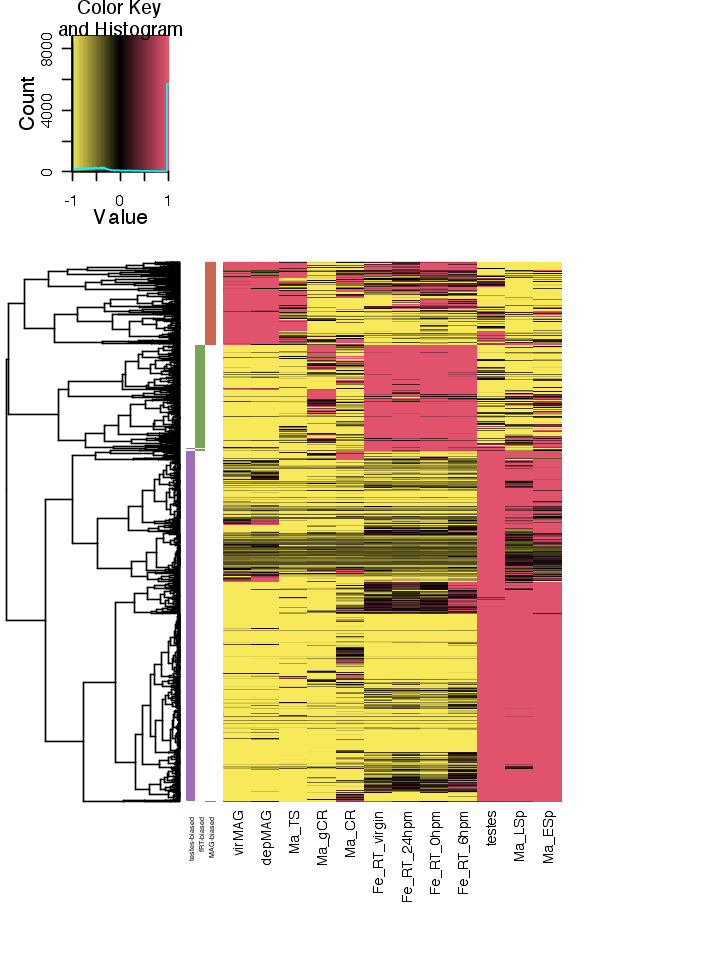

In [51]:
options(repr.plot.width = 6, repr.plot.height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.9, labRow = F)

Let's take a look at the transferred mRNAs from Catalina's paper:

In [52]:
tmRNA.mstrg_IDs = unique(subset(geneFeatures, gene_ID %in% tmRNA$V1)$mstrg_ID)
tmRNA.TPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% tmRNA.mstrg_IDs)

In [53]:
data = tmRNA.TPM
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#79cf3a','black','#fb266a')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

for plotting:: min.raw: -1 max.raw: 1


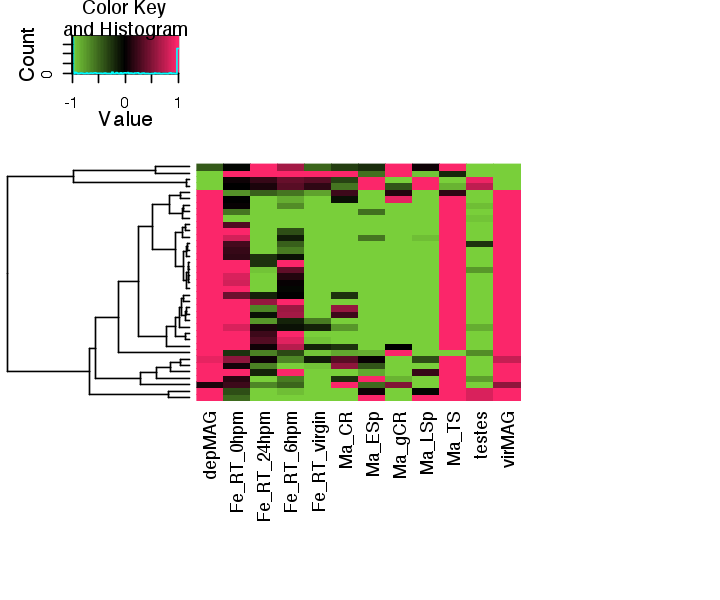

In [54]:
options(repr.plot.width = 6, repr.plot.height = 5)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv=c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "virMAG", "depMAG"), col=myheatcol, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

Here we'll perform a GO enrichment analysis of the genes with ≥4-fold tissue-bias. First we need to set the gene names to VectorBase IDs (note we are already using genes that are VectorBase annotated, we're just changing the IDs to those that correspond to the GOinfo table) *** Using the MAG.up.list instead of the ≥4-fold list, which results in only 2 enriched categories ***:

In [55]:
MAG.VB_IDs.list = unique(subset(gene.features, gene_id %in% MAG.DEup.list & ref_gene_id != "NA")$ref_gene_id)
testes.VB_IDs.list = unique(subset(gene.features, gene_id %in% testes.extreme.list.CDS & ref_gene_id != "NA")$ref_gene_id)
fRT.VB_IDs.list = unique(subset(gene.features, gene_id %in% fRT.extreme.list.CDS & ref_gene_id != "NA")$ref_gene_id)

Now we can create a factor labeling table for this set of gene IDs, as we did for the heatmap:

In [56]:
MAG_vb_factors = as.data.frame(MAG.VB_IDs.list)
MAG_vb_factors$V1 = "MAG-biased"
rownames(MAG_vb_factors) = MAG.VB_IDs.list
MAG_vb_factors = subset(MAG_vb_factors, select = "V1")

testes_vb_factors = as.data.frame(testes.VB_IDs.list)
testes_vb_factors$V1 = "testes-biased"
rownames(testes_vb_factors) = testes.VB_IDs.list
testes_vb_factors = subset(testes_vb_factors, select = "V1")

fRT_vb_factors = as.data.frame(fRT.VB_IDs.list)
fRT_vb_factors$V1 = "fRT-biased"
rownames(fRT_vb_factors) = fRT.VB_IDs.list
fRT_vb_factors = subset(fRT_vb_factors, select = "V1")

vb.factor.labeling = rbind(MAG_vb_factors, testes_vb_factors, fRT_vb_factors)
colnames(vb.factor.labeling) = c('tissue_bias')
vb_factor_list = unique(vb.factor.labeling[,1])

Now we need to extract the gene lengths and merge them with the new ID format:

In [57]:
tmpData = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
tmpData = unique(merge(tmpData, gene_lengths, by.x = "gene_id", by.y = "gene_id"))
vb_gene_lengths = subset(tmpData, ref_gene_id != "NA")
vb_gene_lengths = subset(vb_gene_lengths, select = c("ref_gene_id", "length"))
colnames(vb_gene_lengths) = c("vb_ID", "length")
vb_gene_lengths <- vb_gene_lengths[order(vb_gene_lengths$vb_ID),]
# vb_gene_lengths = as.matrix(vb_gene_lengths)
rownames(vb_gene_lengths) <- vb_gene_lengths$vb_ID
vb_gene_lengths[,1] <- NULL

Load the GO info here:

In [58]:
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = vb_gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

And set the null expectation based on the entire dataset:

Warning message in pcls(G):
"initial point very close to some inequality constraints"

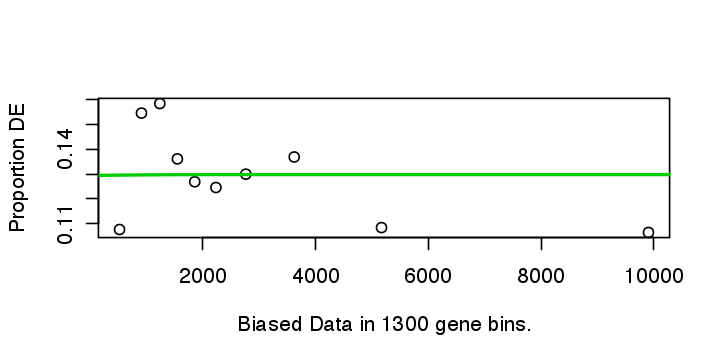

In [59]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% rownames(vb.factor.labeling))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

Finally, we can loop over the tissue-biased gene categories and perform the GO analysis on each gene set:

In [60]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in vb_factor_list) {
#     message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(vb.factor.labeling)[vb.factor.labeling$tissue_bias == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))

GO_enrichment_data = rbindlist(GO_enriched_list)

We can make some bubble plots to quickly look at over-represented terms:

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
"Removed 11 rows containing missing values (geom_point)."Warning message:
"Removed 11 rows containing missing values (geom_text_repel)."

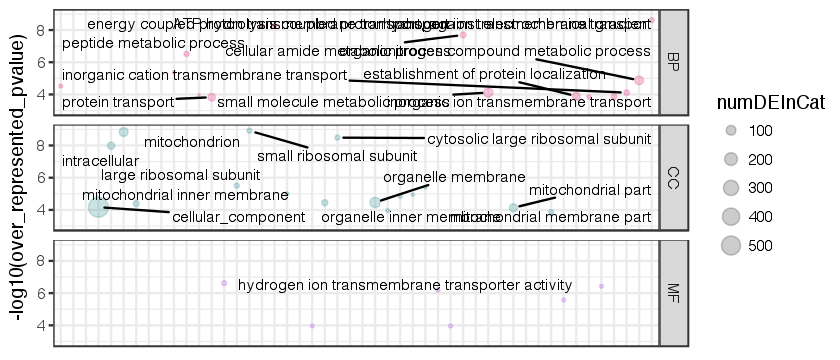

In [61]:
### MAG plot
options(repr.plot.width = 7, repr.plot.height = 3)

ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "MAG-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "MAG-biased" & numDEInCat > 10), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,5)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
"Removed 36 rows containing missing values (geom_point)."Warning message:
"Removed 3 rows containing missing values (geom_text_repel)."

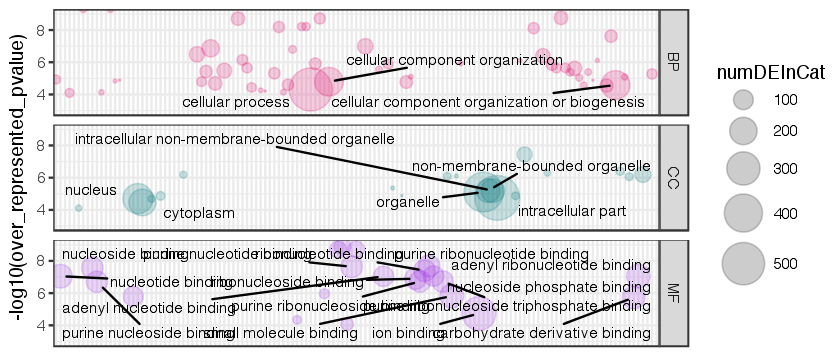

In [62]:
### testes plot
options(repr.plot.width = 7, repr.plot.height = 3)
#pdf("RT-biased.GO.pdf", width = 8.10, height = 3)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.01 & factor == "testes-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.01 & factor == "testes-biased" & numDEInCat > 100), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
"Removed 2 rows containing missing values (geom_point)."

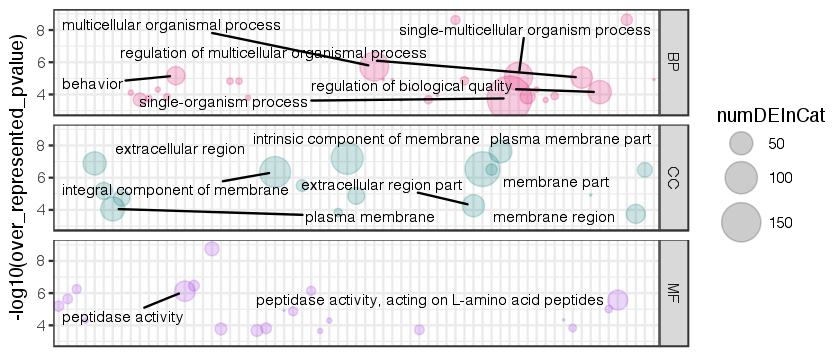

In [63]:
### fRT plot
options(repr.plot.width = 7, repr.plot.height = 3)
#pdf("RT-biased.GO.pdf", width = 8.10, height = 3)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "fRT-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "fRT-biased" & numDEInCat > 30), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

## DE analysis with just Ethan's data:

We can now explore differential expression between the virgin and mated MAG samples. First we'll subset the 3\`RNAseq samples from the `sampleData` object, then define the groups and design matrix:

In [64]:
e.groups = factor(subset(sampleData, Source == "Degner")$Sample)
e.design = model.matrix( ~ 0 + e.groups)
colnames(e.design) <- levels(e.groups)
rownames(e.design) <- subset(sampleData, Source == "Degner")$Replicate

Now we'll filter the count matrix:

In [65]:
# Now filter this subsetted count matrix:
e.CPM <- cpm(ethan.countsMatrix)
e.thresh <- e.CPM > 5
e.keep <- rowSums(e.thresh) >= 4
e.counts.keep <- ethan.countsMatrix[e.keep,]
nrow(e.counts.keep)

[1] 9417

Now create the DGE object and run the glm fit:

In [66]:
e.dgeList <- DGEList(counts = e.counts.keep, group = e.groups)
e.dgeList <- calcNormFactors(e.dgeList)
e.dgeList <- estimateCommonDisp(e.dgeList)
e.dgeList <- estimateTagwiseDisp(e.dgeList)
e.dgeList_fit <- glmFit(e.dgeList, e.design)

...add annotation information:

In [67]:
# Extract annotation for genes in the fit object
ann.e = subset(annots, mstrg_ID %in% rownames(e.dgeList_fit))
# convert factors to characters
ann.e = data.frame(lapply(ann.e, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.e = ann.e[match(rownames(e.dgeList_fit), ann.e$mstrg_ID),]
# convert factors to characters, again
ann.e <- data.frame(lapply(ann.e, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.e) = c ("GeneID", "VB_ID", "gene_name","Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.e$GeneID==rownames(e.dgeList_fit))
# Add the annotations to the fit object in the "genes" slot
e.dgeList_fit$genes = ann.e


TRUE 
9417 

We can look at the variability by examining the tagwise dispersion:

In [68]:
summary(e.dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04987 0.09280 0.11560 0.19420 0.17880 3.64000 

We can take a closer look at the DE materics and whether overall variability in the counts is suitable by plotting the BCV, looking at the mean-variance trend and QQplot:

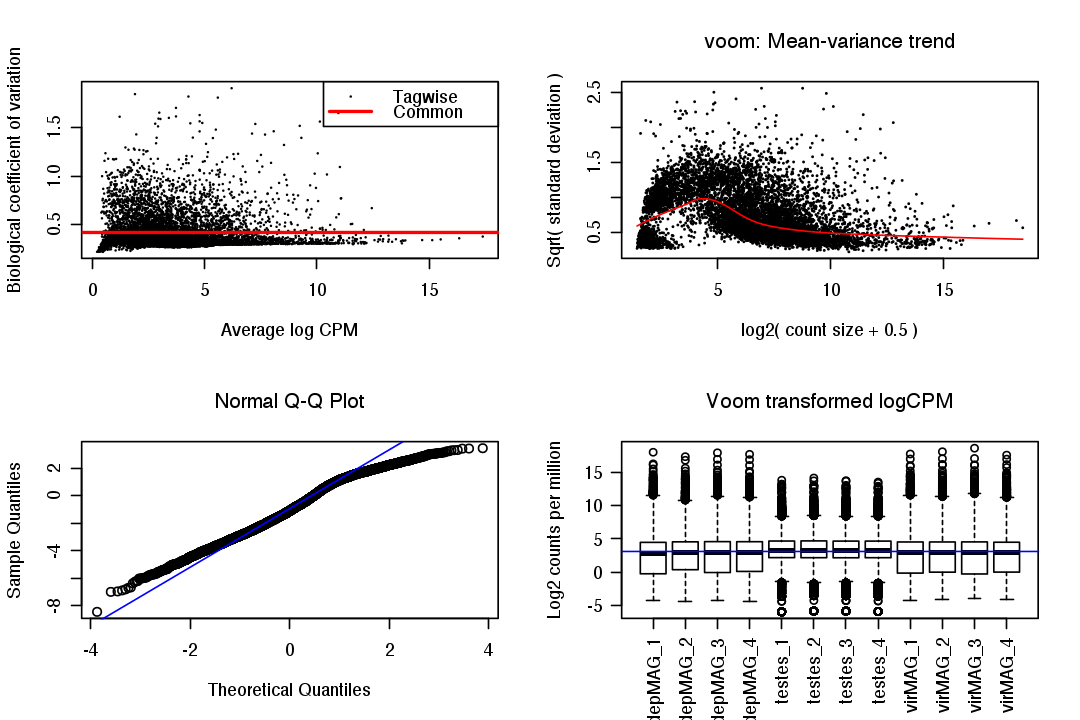

In [69]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(e.dgeList)
# mean-variance trend
voomC = voom(e.dgeList, e.design, plot=TRUE)
# QQ-plot
g <- gof(e.dgeList_fit)
z <- zscoreGamma(g$gof.statistics,shape=g$df/2,scale=2)
qqnorm(z); qqline(z, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voomC$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voomC$E),col="blue")

We'll set up the contrast between the virgin and depleted MAG samples, and between the virgin MAG and testes:

In [70]:
vMAG.v.dMAG <- makeContrasts(vMAG.vs.dMAG=virMAG-depMAG,
                             levels=e.design)

vMAG.v.testes <- makeContrasts(vMAG.vs.testes=virMAG-testes,
                               levels=e.design)

Now run the LRT on the fit object to identify differentially expressed genes:

In [71]:
lrt.dvMAG <- glmLRT(e.dgeList_fit, contrast = vMAG.v.dMAG)
lrt.testes_vMAG <- glmLRT(e.dgeList_fit, contrast = vMAG.v.testes)

We'll extract the genes that are >2-fold up- or down-regulated at an FDR cutoff of 0.01:

In [72]:
lrt.dvMAG.tTags <- topTags(lrt.dvMAG, n = NULL)
lrt.dvMAG.tTags.table <- lrt.dvMAG.tTags$table

# create a list of all DE genes:
dvMAG.DE.list<-subset(lrt.dvMAG.tTags.table, logFC < -1 & FDR<0.01 | logFC > 1 & FDR<0.01)$GeneID
dvMAG.DE.list.CDS  = unique(subset(gene.features, gene_id %in% dvMAG.DE.list & ref_gene_id != "NA")$gene_id)

# and a list of up-regulated and down-regulated genes:
virUP.list<-subset(lrt.dvMAG.tTags.table, logFC > 1 & FDR<0.01)$GeneID
depUP.list<-subset(lrt.dvMAG.tTags.table, logFC < -1 & FDR<0.01)$GeneID

virUP.list.CDS = unique(subset(gene.features, gene_id %in% virUP.list & ref_gene_id != "NA")$gene_id)
virDOWN.list.CDS = unique(subset(gene.features, gene_id %in% depUP.list & ref_gene_id != "NA")$gene_id)

paste("The number of gene transcripts the are differentially expressed between virgin and depleted MAGs is ", length(dvMAG.DE.list), ", of which ", length(dvMAG.DE.list.CDS), " are annotated protein coding genes. Of these, ", length(virUP.list.CDS), " show significantly higher expression in the virgin MAGs, and ", length(virDOWN.list.CDS), " go up in expression after mating", sep="")

[1] "The number of gene transcripts the are differentially expressed between virgin and depleted MAGs is 522, of which 446 are annotated protein coding genes. Of these, 126 show significantly higher expression in the virgin MAGs, and 320 go up in expression after mating"

We'll extract the tTags table for the vMAG/testes comparison:

In [73]:
lrt.testes_vMAG.tTags <- topTags(lrt.testes_vMAG, n = NULL)
lrt.testes_vMAG.tTags.table <- lrt.testes_vMAG.tTags$table

For two samples it's often convenient to look at a volcano plot. With edgeR we can produce interactive volcano plots. First we need to run the glmTreat model:

In [74]:
lrt_dMAG.v.vMAG <- glmTreat(e.dgeList_fit, contrast = c(-1,0,1), lfc =1)
lrt_vMAG.v.testes <- glmTreat(e.dgeList_fit, contrast = c(0,-1,1), lfc =1)

Then run the decide test

In [75]:
dt.dvMAG = decideTestsDGE(lrt_dMAG.v.vMAG)
dt.TvMAG = decideTestsDGE(lrt_vMAG.v.testes)

Also subset the data info:

In [76]:
sampleData.e = subset(sampleData, Source == "Degner")

Now make the plot:

In [77]:
glXYPlot(x=lrt_dMAG.v.vMAG$table$logFC, y=-log10(lrt_dMAG.v.vMAG$table$PValue), xlab="logFC", ylab="logodds", status=dt.dvMAG, groups=sampleData.e$Sample, side.main="gene_name", anno = ann.e, counts = e.dgeList)

In [78]:
glXYPlot(x=lrt_vMAG.v.testes$table$logFC, y=-log10(lrt_vMAG.v.testes$table$PValue), xlab="logFC", ylab="logodds", status=dt.TvMAG, groups=sampleData.e$Sample, side.main="gene_name", anno = ann.e, counts = e.dgeList)

We can clearly see there are more genes that go up in expression after mating. We'll also generate a static volcano plot for later (will highlight highly significant genes):

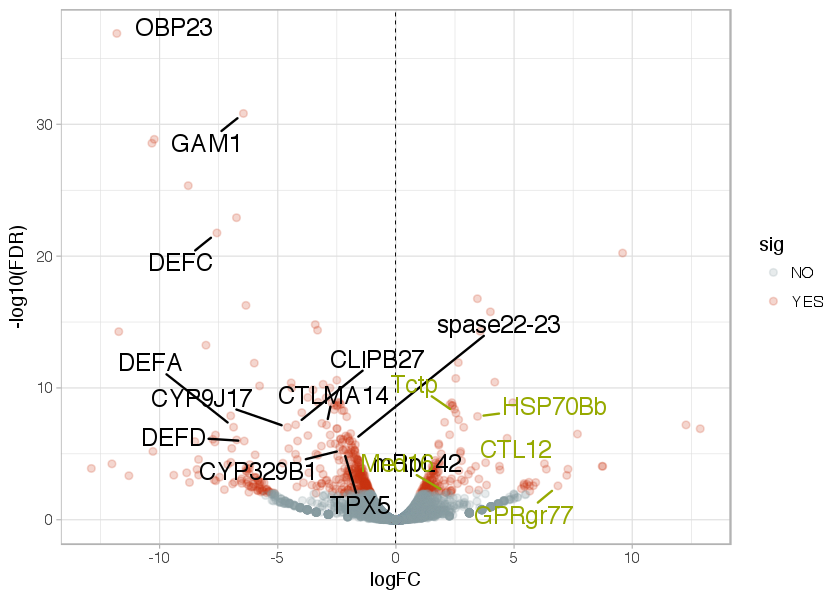

In [79]:
tmpVolcano = lrt.dvMAG.tTags.table
tmpVolcano$sig = ifelse(tmpVolcano$FDR < 0.01 & tmpVolcano$logFC > 1 | tmpVolcano$FDR < 0.01 & tmpVolcano$logFC < -1, "YES", "NO")

options(repr.plot.width = 7, repr.plot.height = 5)
ggplot(tmpVolcano, aes(logFC, -log10(FDR), colour = sig)) + 
    geom_vline(xintercept = 0, linetype = "dashed", size = 0.2) +
    geom_point(alpha=0.2) + 
    geom_text_repel(data = subset(tmpVolcano, logFC < -1 & -log10(FDR) > 5 & !is.na(gene_name)), 
                    aes(logFC, -log10(FDR),label=gene_name), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 5,
                    colour = "black") +
    geom_text_repel(data = subset(tmpVolcano, logFC > 2 & -log10(FDR) > 1 & !is.na(gene_name)), 
                    aes(logFC, -log10(FDR),label=gene_name), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 5,
                    colour = "#96a900") +
    scale_colour_manual(values = wes_palette("Royal1")) +
    theme_light()

We can look at whether any GO terms are enriched among the up- or down-regulated genes. First generate the factor labeling table with the two gene classes:

In [80]:
deMAG.up.VB_IDs.list = unique(subset(gene.features, gene_id %in% virUP.list.CDS & ref_gene_id != "NA")$ref_gene_id)
deMAG.down.VB_IDs.list = unique(subset(gene.features, gene_id %in% virDOWN.list.CDS & ref_gene_id != "NA")$ref_gene_id)

deMAG.up_vb_factors = as.data.frame(deMAG.up.VB_IDs.list)
deMAG.up_vb_factors$V1 = "Upregulated"
rownames(deMAG.up_vb_factors) = deMAG.up.VB_IDs.list
deMAG.up_vb_factors = subset(deMAG.up_vb_factors, select = "V1")

deMAG.down_vb_factors = as.data.frame(deMAG.down.VB_IDs.list)
deMAG.down_vb_factors$V1 = "Downregulated"
rownames(deMAG.down_vb_factors) = deMAG.down.VB_IDs.list
deMAG.down_vb_factors = subset(deMAG.down_vb_factors, select = "V1")

deMAG.factor.labeling = rbind(deMAG.up_vb_factors, deMAG.down_vb_factors)
colnames(deMAG.factor.labeling) = c('DE_status')
deMAG_factor_list = unique(deMAG.factor.labeling[,1])

Set up the null as before:

Warning message in pcls(G):
"initial point very close to some inequality constraints"

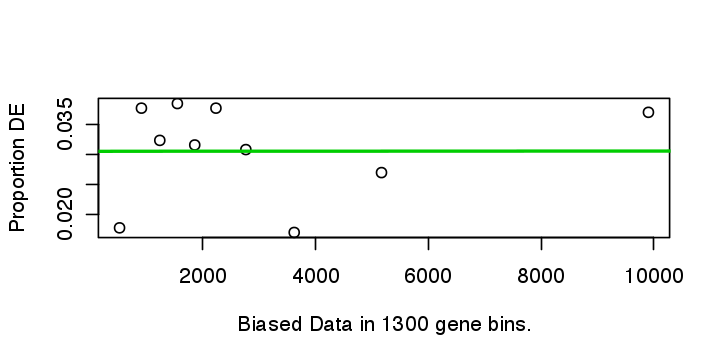

In [81]:
options(repr.plot.width = 6, repr.plot.height = 3)

cat_genes_vec = as.integer(features_with_GO %in% rownames(deMAG.factor.labeling))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

output the enrichment result:

In [82]:
GO_enriched_list = list()

for (feature_cat in deMAG_factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(deMAG.factor.labeling)[deMAG.factor.labeling$DE_status == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: Upregulated
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: Downregulated
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Now we'll look at a summary using bubble plots:

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
"Removed 4 rows containing missing values (geom_point)."Warning message:
"Removed 2 rows containing missing values (geom_text_repel)."

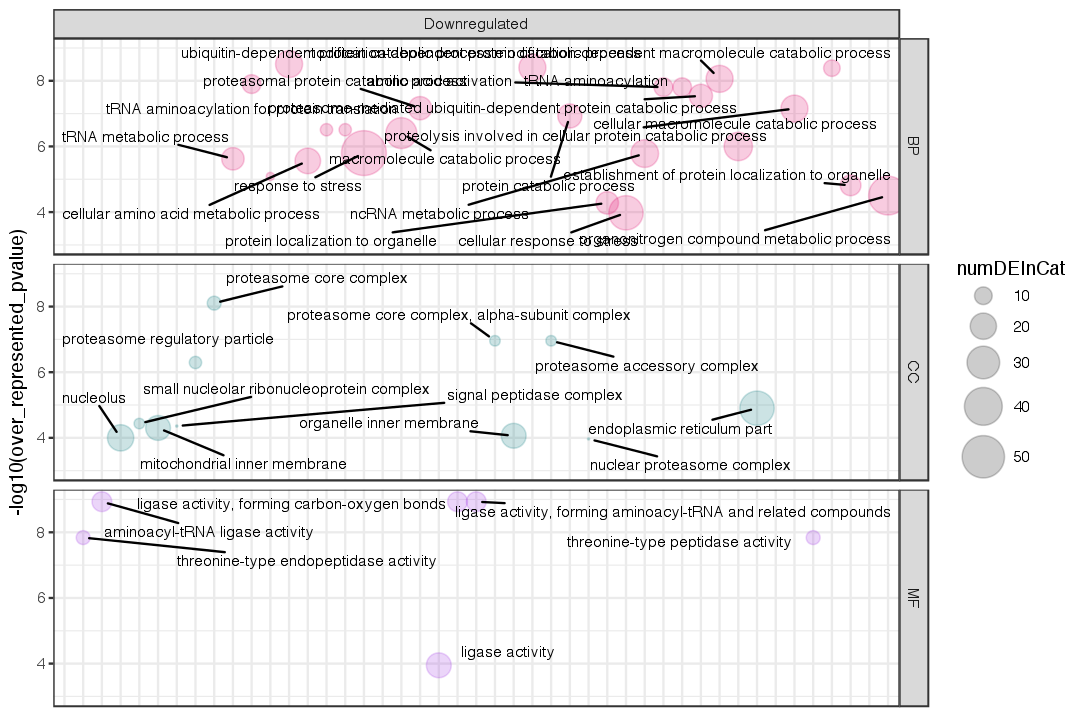

In [83]:
options(repr.plot.width = 9, repr.plot.height = 6)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~factor) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 10 & ontology == "BP"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 10, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "CC"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "MF"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

There appears to be no enrichment among genes that go down in expression after mating, but several enriched terms among genes that are upregulated in the depleted MAG sample.

# Proteome data

Load the final proteomics data file:

In [84]:
proteome_data = read.csv("proteomics/complete_result.txt", header = T, sep = "\t")

And the raw spectral data:

In [85]:
peptide_data = read.csv("proteomics/raw_comet_tandem_combined.txt", header = T, sep = "\t")
# xtandem = merge(xtandem, subset(genbank_proteins, protein_name %in% xtandem$protein_name), by.x = "protein_name", by.y = "protein_name")

All the proteomics analysis was performed on the NCBI IDs, and does not contain the new VectorBase IDs. We'll combine the IDs from the new annotation with the NCBI annotation and MSTRG IDs here:

In [86]:
# first subset the geneFeatures object to include data present in the proteome_data object:
tmpFile = unique(subset(geneFeatures, loc_ID %in% proteome_data$gene))
# Select only the relevant columns from the above file:
proteome_IDs = unique(subset(tmpFile, select = c("mstrg_ID", "gene_ID", "loc_ID", "gene_name")))
# Now create a new object with the proteome data with the full ID set:
ejaculotome1 = merge(proteome_IDs, proteome_data, by.x = "loc_ID", by.y = "gene", all = TRUE)
rm(tmpFile)

We can load the protein abundance data produced by APEX, which also uses the NCBI IDs, and combine it with the rest of the ejaculotome data:

In [87]:
apex = read.csv("proteomics/APEX_semen_v_sperm_longest_full_comb_comet_V2.txt", header = T, sep = "\t")
ejaculotome2 = merge(ejaculotome1, apex, by.x = "loc_ID", by.y = "ACC", all = TRUE)

We'll also load the Sirot 2011 data:

In [88]:
sirot = read.csv("annotation/sirot/Sirot_combined_SFP_and_sperm.txt", header = T, sep = "\t")
sirot_SFPs = subset(sirot, Sirot_classification == "SFP" & L5_geneID != "NA")$L5_geneID
sirot_Sps = subset(sirot, Sirot_classification == "Sperm" & L5_geneID != "NA")$L5_geneID

paste("There are ", length(sirot_SFPs), " genes from the Sirot study that are classified as SFPs")

[1] "There are  82  genes from the Sirot study that are classified as SFPs"

We can merge the sirot data with the ejaculotome data, but note that Sirot loc_IDs with NA's will be added, but have no merge reference in the ejaculotome object:

In [89]:
ejaculotome3 = merge(ejaculotome2, sirot, by.x = "loc_ID", by.y = "L5_geneID", all = T)

Finally, we can combine the gene expression abundance data with the proteome data:

In [90]:
proteome_TPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% ejaculotome3$mstrg_ID)
proteome_TPM$gene_id = rownames(proteome_TPM)
ejaculotome4 = merge(ejaculotome3, proteome_TPM, by.x = "mstrg_ID", by.y = "gene_id", all = T)

Add differential expression data from virgin and mated MAG comparison:

In [91]:
MAG.DE_in_proteome = subset(lrt.dvMAG.tTags.table, GeneID %in% ejaculotome4$mstrg_ID)
MAG.DE_in_proteome = subset(MAG.DE_in_proteome, select = c("GeneID", "logFC", "LR", "PValue", "FDR"))
colnames(MAG.DE_in_proteome) = c("GeneID", "edgeR_logFC_MAGs", "edgeR_LR_MAGs", "edgeR_PValue_MAGs", "edgeR_FDR_MAGs")
ejaculotome5 = merge(ejaculotome4, MAG.DE_in_proteome, by.x = "mstrg_ID", by.y = "GeneID", all = T)

And differential expression data between virgin MAG and testes:

In [92]:
TS_v_MAG.DE_in_proteome = subset(lrt.testes_vMAG.tTags.table, GeneID %in% ejaculotome5$mstrg_ID)
TS_v_MAG.DE_in_proteome = subset(TS_v_MAG.DE_in_proteome, select = c("GeneID", "logFC", "LR", "PValue", "FDR"))
colnames(TS_v_MAG.DE_in_proteome) = c("GeneID", "edgeR_logFC_MAGvT", "edgeR_LR_MAGvT", "edgeR_PValue_MAGvT", "edgeR_FDR_MAGvT")
ejaculotome6 = merge(ejaculotome5, TS_v_MAG.DE_in_proteome, by.x = "mstrg_ID", by.y = "GeneID", all = T)

Extract signal peptide data, and merge with above:

In [93]:
signalP_proteome_data = unique(subset(trinotate, select = c("gene_id", "SignalP")))
signalP_proteome_data = subset(signalP_proteome_data, gene_id %in% ejaculotome5$gene_ID)
signalP_proteome_data = aggregate(SignalP~gene_id, data = signalP_proteome_data, toString)
ejaculotome7 = merge(ejaculotome6, signalP_proteome_data, by.x = "gene_ID", by.y = "gene_id", all = TRUE)

We'll add the raw spectral data:

In [94]:
ejaculotome8 = merge(ejaculotome7, peptide_data, by.x = "loc_ID", by.y = "protein_name", all = TRUE)

Finally we'll combine the expression status data from the RNAseq run:

In [95]:
ejaculotome9 = merge(ejaculotome8, expression.status, by.x = "mstrg_ID", by.y = "mstrg_ID", all.x = T)

This section adds chromosome coordinate information:

In [96]:
coords_proteome = subset(gene.features, gene_id %in% ejaculotome8$mstrg_ID & !is.na(ref_gene_id))
coords_proteome = unique(subset(coords_proteome, select = c("contig", "min", "gene_id")))
ag <- aggregate(min~gene_id, coords_proteome, min)
coords_proteome = merge(ag, coords_proteome)
ejaculotome10 = merge(ejaculotome9, coords_proteome, by.x = "mstrg_ID", by.y = "gene_id")

We'll assign this final table to the stable object:

In [97]:
ejaculotome_all = ejaculotome10

To run various analyses, we'll need to add additional customizations based on the data that's already there:

In [98]:
tmpDF = ejaculotome_all
# get a log2 fold value for APEX differential abundance
tmpDF$logFold = log2(tmpDF$APEX_FOLD)

# multiple the APEX abundance value by a million
tmpDF$APEX_semen_VPM = tmpDF$APEX_semen * 1000000
tmpDF$APEX_sperm_VPM = tmpDF$APEX_sperm * 1000000

# create a column that assigns a -ve value to proteins with higher abundance in semen
tmpDF$Signfold = ifelse(tmpDF$Semen_more_than_Sperm == "TRUE", tmpDF$logFold * -1, tmpDF$logFold)

# add a column for APEX significance when FDR < 0.05 and fold-change is ≥2-fold
tmpDF$sig = ifelse(tmpDF$recalc_FDR < 0.05 & tmpDF$Signfold > 1 | tmpDF$recalc_FDR < 0.05 & tmpDF$Signfold < -1, "YES", "NO")

# add a YES/NO column for proteins present in only sperm or semen
tmpDF$semen_status = ifelse(tmpDF$semen.only == "1", "YES", "NO")
tmpDF$sperm_status = ifelse(tmpDF$sperm.only == "1", "YES", "NO")

# add a YES/NO column for proteins with a signal peptide seqeunce
tmpDF$signalP = ifelse(tmpDF$SignalP != ".", "YES", "NO")

# add a column for maximum number of total and unique peptides observed in either the comet, tandem, or combined iProphet searches for both the sperm and semen samples:
# semen
semen_t_Peptide_counts = subset(tmpDF, select = c("semen_comet.total_peptides", "semen_combined.total_peptides", "semen_tandem.total_peptides"))
semen_t_Peptide_counts[is.na(semen_t_Peptide_counts)] <- 0
semen_MAX.total_peptides <- apply(semen_t_Peptide_counts, 1, max)

semen_u_Peptide_counts = subset(tmpDF, select = c("semen_comet.unique_peptides", "semen_combined.unique_peptides", "semen_tandem.unique_peptides"))
semen_u_Peptide_counts[is.na(semen_u_Peptide_counts)] <- 0
semen_MAX.unique_peptides <- apply(semen_u_Peptide_counts, 1, max)

tmpDF$semen_MAX.total_peptides = semen_MAX.total_peptides
tmpDF$semen_MAX.unique_peptides = semen_MAX.unique_peptides

# sperm
sperm_t_Peptide_counts = subset(tmpDF, select = c("sperm_comet.total_peptides", "sperm_combined.total_peptides", "sperm_tandem.total_peptides"))
sperm_t_Peptide_counts[is.na(sperm_t_Peptide_counts)] <- 0
sperm_MAX.total_peptides <- apply(sperm_t_Peptide_counts, 1, max)

sperm_u_Peptide_counts = subset(tmpDF, select = c("sperm_comet.unique_peptides", "sperm_combined.unique_peptides", "sperm_tandem.unique_peptides"))
sperm_u_Peptide_counts[is.na(sperm_u_Peptide_counts)] <- 0
sperm_MAX.unique_peptides <- apply(sperm_u_Peptide_counts, 1, max)

tmpDF$sperm_MAX.total_peptides = sperm_MAX.total_peptides
tmpDF$sperm_MAX.unique_peptides = sperm_MAX.unique_peptides


We can write this out to a file

In [99]:
ejaculotome_all = tmpDF
write.table(ejaculotome_all, file = "Results/Ejaculotome_db.txt", quote = F, sep = "\t", row.names = F)

Using this tmpDF object, many plots and analyses can be produced. One example plot is a volcano plot of the APEX abundnace data:

Warning message:
"Removed 974 rows containing missing values (geom_point)."

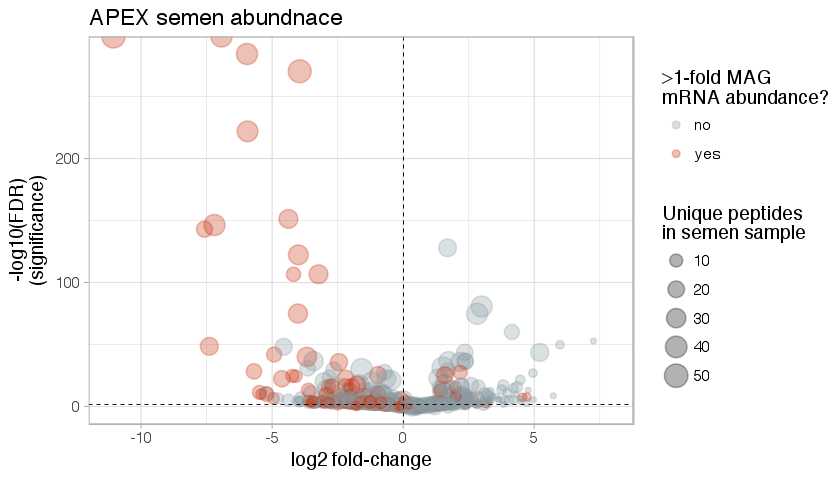

In [100]:
options(repr.plot.width = 7, repr.plot.height = 4)
# pdf("Figures/APEX_abundance_semen.pdf", width = 7, height = 4)
ggplot(subset(tmpDF, !is.na(MAG_oneFold_bias)), aes(Signfold, -log10(recalc_FDR), colour = MAG_oneFold_bias, size = semen_combined.unique_peptides)) + 
    geom_point(alpha=0.3) + 
    labs(title = "APEX semen abundnace", x = "log2 fold-change", y = "-log10(FDR)\n(significance)", color = ">1-fold MAG\nmRNA abundance?", size = "Unique peptides\nin semen sample") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.2) +
    geom_vline(xintercept = 0, linetype = "dashed", size = 0.2) +
    scale_colour_manual(values = wes_palette("Royal1")) +
    theme_light()
# dev.off()

Warning message:
"Removed 968 rows containing missing values (geom_point)."

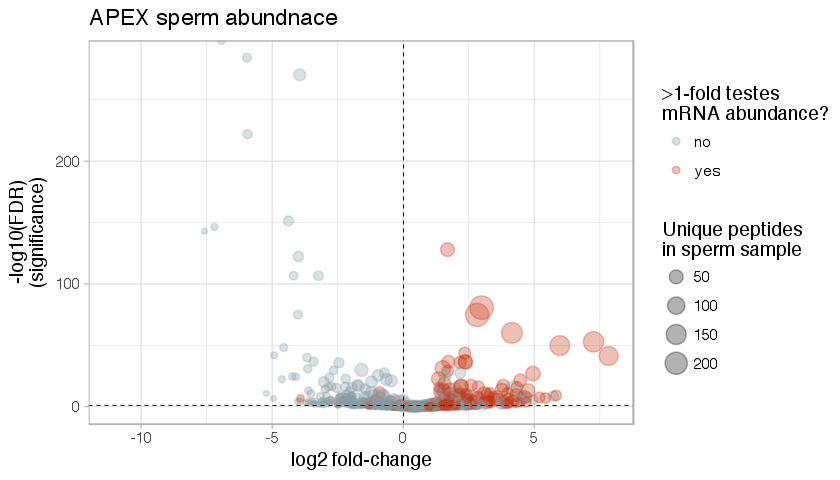

In [101]:
options(repr.plot.width = 7, repr.plot.height = 4)
# pdf("Figures/APEX_abundance_sperm.pdf", width = 7, height = 4)
ggplot(subset(tmpDF, !is.na(testes_oneFold_bias)), aes(Signfold, -log10(recalc_FDR), colour = testes_oneFold_bias, size = sperm_combined.unique_peptides)) + 
    geom_point(alpha=0.3) + 
    labs(title = "APEX sperm abundnace", x = "log2 fold-change", y = "-log10(FDR)\n(significance)", color = ">1-fold testes\nmRNA abundance?", size = "Unique peptides\nin sperm sample") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.2) +
    geom_vline(xintercept = 0, linetype = "dashed", size = 0.2) +
    scale_colour_manual(values = wes_palette("Royal1")) +
    theme_light()
# dev.off()

We can look at the relationship between the APEX abundance value, the total number of peptides, and the number of unique peptides (semen, combined sample):

Warning message:
"Removed 755 rows containing missing values (geom_point)."

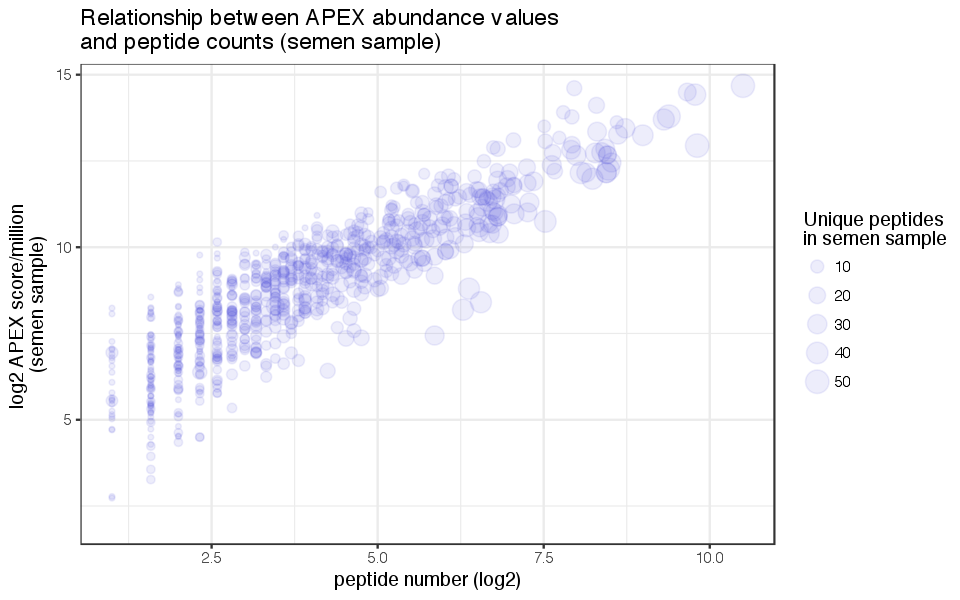

In [102]:
options(repr.plot.width = 8, repr.plot.height = 5)
# pdf("Figures/APEX_vs_peptide_number.pdf", width = 7, height = 4)
ggplot(tmpDF, aes(log2(semen_combined.total_peptides), log2(APEX_semen_VPM), size = semen_combined.unique_peptides)) + geom_point(alpha = 0.1, colour = "#5652d8") + 
labs(title = "Relationship between APEX abundance values \nand peptide counts (semen sample)", x = "peptide number (log2)", y = "log2 APEX score/million \n(semen sample)", size = "Unique peptides\nin semen sample") + 
theme_bw()
# dev.off()

One other example is correplation between APEX abundance values and RNAseq abundance estimates for SFPs:

Warning message:
"Removed 46 rows containing missing values (geom_point)."

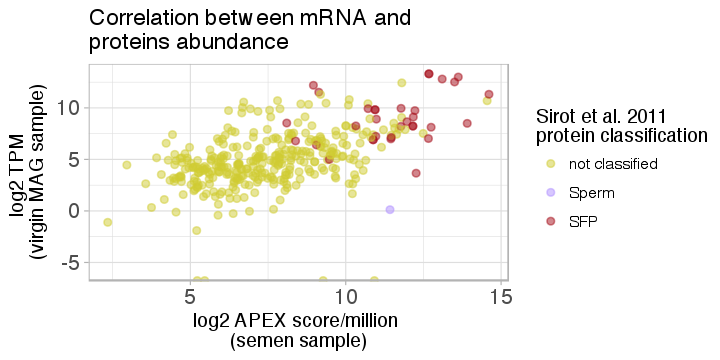

In [103]:
tmpDF$Sirot_classification <- as.character(tmpDF$Sirot_classification)
tmpDF$Sirot_classification <- ifelse(is.na(tmpDF$Sirot_classification), 
             'not classified', tmpDF$Sirot_classification)
tmpDF$Sirot_classification = factor(tmpDF$Sirot_classification, levels = c("not classified", "Sperm", "SFP"))

options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("Figures/mRNA_vs_APEX.pdf", width = 7, height = 4)
ggplot(subset(tmpDF, semen_status == "YES"), aes(log2(APEX_semen_VPM), log2(virMAG), colour = Sirot_classification)) + 
geom_point(alpha = 0.5) + 
labs(title = "Correlation between mRNA and \nproteins abundance", x = "log2 APEX score/million \n(semen sample)", y = "log2 TPM \n(virgin MAG sample)", colour = "Sirot et al. 2011 \nprotein classification") +
scale_colour_manual(values = c("#d0cb32", "#b090ff", "#a60f1a")) +
theme_light() +
theme(axis.text = element_text(size = 12))
# dev.off()

#### Defining the sperm proteome and SFPs:

Using this `tmpDF` object, we'd like to define the two proteins classes we're interested in, i.e. sperm proteins and SFPs. Beecause there are several ways this can be acheived, we'll explore a few possibilities and assess the list by performing GO analysis and checking which proteins are left out.

##### 1. Using the decay curve to estimate the number of proteins:

First estimate the number of proteins based on a minimum peptide count cutoff (for total peptides and unique peptides separately):

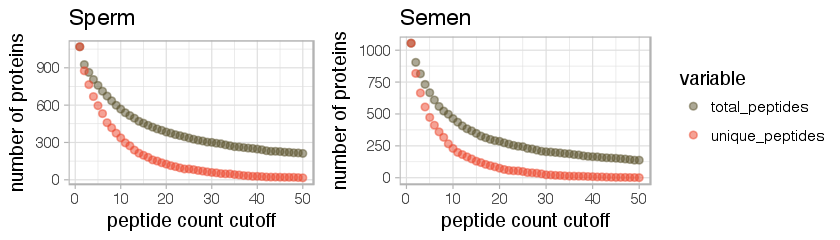

In [104]:
## Sperm
# start an empty object
sperm_uniqueDF = NULL
sperm_totalDF = NULL

# loop over a range of peptide count values and capture the number of proteins for each value
for (i in 1:50) {
    sperm_totalDF[i] = nrow(subset(tmpDF, sperm.union.full == 1 & sperm_MAX.total_peptides >= i))
    sperm_uniqueDF[i] = nrow(subset(tmpDF, sperm.union.full == 1 & sperm_MAX.unique_peptides >= i))
}

# Createa dataframe with the above output
Sp_pep_co = data.frame(peptide_cutoff = seq(1,50,1), total_peptides = sperm_totalDF, unique_peptides = sperm_uniqueDF)
Sp_pep_co = melt(Sp_pep_co, id.vars = "peptide_cutoff")


## Semen
# start an empty object
semen_uniqueDF = NULL
semen_totalDF = NULL

# loop over a range of peptide count values and capture the number of proteins for each value
for (i in 1:50) {
    semen_totalDF[i] = nrow(subset(tmpDF, semen.union.full == 1 & semen_MAX.total_peptides >= i))
    semen_uniqueDF[i] = nrow(subset(tmpDF, semen.union.full == 1 & semen_MAX.unique_peptides >= i))
}

# Createa dataframe with the above output
Se_pep_co = data.frame(peptide_cutoff = seq(1,50,1), total_peptides = semen_totalDF, unique_peptides = semen_uniqueDF)
Se_pep_co = melt(Se_pep_co, id.vars = "peptide_cutoff")


Sp_pep_gg = ggplot(Sp_pep_co, aes(peptide_cutoff, value, colour = variable)) + 
geom_point(alpha = 0.5) +
theme_light() +
labs(title = "Sperm", x = "peptide count cutoff", y = "number of proteins") +
scale_colour_manual(values = c("#5a532c","#eb462d")) +
theme(legend.position = "none")

Se_pep_gg = ggplot(Se_pep_co, aes(peptide_cutoff, value, colour = variable)) + 
geom_point(alpha = 0.5) +
theme_light() +
labs(title = "Semen", x = "peptide count cutoff", y = "number of proteins") +
scale_colour_manual(values = c("#5a532c","#eb462d"))

options(repr.plot.width = 7, repr.plot.height = 2)
# pdf("~/Desktop/peptide.cutoff.pdf", width = 7, height = 2)
plot_grid(Sp_pep_gg, Se_pep_gg, ncol = 2, rel_widths = c(1,1.6))
# dev.off()

##### 2. Histogram of peptide counts:

We'd like to know what the peptide count ditribution. we'll plot a histogram of total and unique peptide counts for protiens detected in the sperm sample:

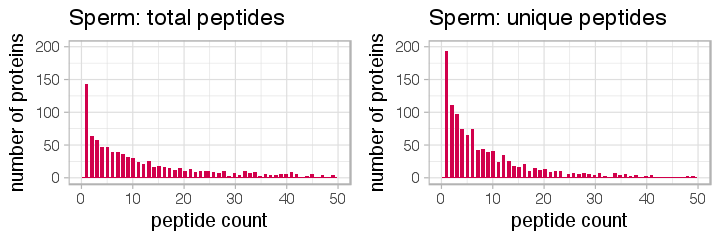

In [105]:
options(repr.plot.width = 6, repr.plot.height = 3)
sp.total_gg = ggplot(subset(tmpDF, sperm.union.full == 1)) + 
    geom_histogram(aes(sperm_MAX.total_peptides), bins = 100, fill = "#d1004b") +   
    scale_x_continuous(limits = c(0,50)) + 
    scale_y_continuous(limits = c(0,200)) +
    labs(title = "Sperm: total peptides", x = "peptide count", y = "number of proteins") +
    theme_light()

sp.unique_gg = ggplot(subset(tmpDF, sperm.union.full == 1)) +    
    geom_histogram(aes(sperm_MAX.unique_peptides), bins = 100, fill = "#d1004b") + 
    scale_x_continuous(limits = c(0,50)) + 
    scale_y_continuous(limits = c(0,200)) +
    labs(title = "Sperm: unique peptides", x = "peptide count", y = "number of proteins") + 
    theme_light()

options(repr.plot.width = 6, repr.plot.height = 2)
# pdf("~/Desktop/peptide_count_decay_sperm.pdf", width = 6, height = 2)
suppressWarnings(plot_grid(sp.total_gg, sp.unique_gg))
# dev.off()

There's a substantial drop from proteins that have one peptide to those with two peptides.

We'll create seevral lists of proteins, first those with at least 2 peptides, then sequentially adding mRNA abundance criteria (expressed, ≥1-fold, ≥2-fold, and ≥4-fold).

First, Proteins with ≥2 unique peptides:

In [106]:
sperm_min2Pep = as.character(unique(subset(tmpDF, sperm_MAX.unique_peptides >= 2)$mstrg_ID))
length(sperm_min2Pep)

[1] 873

≥2 unique peptides and TPM >1:

In [107]:
sperm_min2Pep_testesExpressed = as.character(unique(subset(tmpDF, sperm_MAX.unique_peptides >= 2 & testes_expressed == "yes")$mstrg_ID))
length(sperm_min2Pep_testesExpressed)

[1] 852

≥2 unique peptides and testes expression ≥1-fold higher than other tissues:

In [108]:
sperm_min2Pep_testes1fold = as.character(unique(subset(tmpDF, sperm_MAX.unique_peptides >= 2 & testes_oneFold_bias == "yes")$mstrg_ID))
length(sperm_min2Pep_testes1fold)

[1] 324

≥2 unique peptides and testes expression ≥2-fold higher than other tissues:

In [109]:
sperm_min2Pep_testes2fold = as.character(unique(subset(tmpDF, sperm_MAX.unique_peptides >= 2 & testes_twoFold_bias == "yes")$mstrg_ID))
length(sperm_min2Pep_testes2fold)

[1] 256

≥2 unique peptides and testes expression ≥4-fold higher than other tissues:

In [110]:
sperm_min2Pep_testes4fold = as.character(unique(subset(tmpDF, sperm_MAX.unique_peptides >= 2 & testes_fourFold_bias == "yes")$mstrg_ID))
length(sperm_min2Pep_testes4fold)

[1] 213

Now we'll look at the peptide count distribution of proteins present in the semen sample:

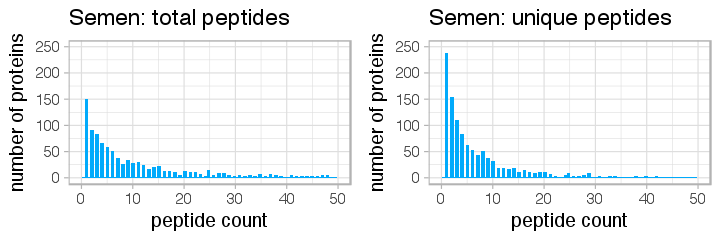

In [111]:
options(repr.plot.width = 6, repr.plot.height = 3)
se.total_gg = ggplot(subset(tmpDF, semen.union.full == 1)) + 
    geom_histogram(aes(semen_MAX.total_peptides), bins = 100, fill = "#01aafb") +   
    scale_x_continuous(limits = c(0,50)) + 
    scale_y_continuous(limits = c(0,250)) +
    labs(title = "Semen: total peptides", x = "peptide count", y = "number of proteins") +
    theme_light()

se.unique_gg = ggplot(subset(tmpDF, semen.union.full == 1)) +    
    geom_histogram(aes(semen_MAX.unique_peptides), bins = 100, fill = "#01aafb") + 
    scale_x_continuous(limits = c(0,50)) + 
    scale_y_continuous(limits = c(0,250)) +
    labs(title = "Semen: unique peptides", x = "peptide count", y = "number of proteins") +
    theme_light()

options(repr.plot.width = 6, repr.plot.height = 2)
# pdf("~/Desktop/peptide_count_decay_semen.pdf", width = 6, height = 2)
suppressWarnings(plot_grid(se.total_gg, se.unique_gg))
# dev.off()

For the SFP category we'll need to look at additional criteria because the semen sample contains both sperm and seminal fluids. One possibility is to use proteins that have higher abundance in the semen sample relative to the sperm sample... however this criteria can only be applied where abundance was estimated for the sperm sample.

Like with the sperm sample, we'll capture the protiens present in the semen sample with ≥2 unique peptides:

In [112]:
semen_min2Pep = as.character(unique(subset(tmpDF, semen_MAX.unique_peptides >= 2)$mstrg_ID))
length(semen_min2Pep)

[1] 814

≥2 unique peptides and TPM > 1

In [113]:
semen_min2Pep_MAGexpressed = as.character(unique(subset(tmpDF, semen_MAX.unique_peptides >= 2 & MAG_expressed == "yes")$mstrg_ID))
length(semen_min2Pep_MAGexpressed)

[1] 741

≥2 unique pepttides and MAG expression ≥1-fold higher than other tissues:

In [114]:
semen_min2Pep_MAG1fold = as.character(unique(subset(tmpDF, semen_MAX.unique_peptides >= 2 & MAG_oneFold_bias == "yes")$mstrg_ID))
length(semen_min2Pep_MAG1fold)

[1] 291

≥2 unique pepttides and MAG expression ≥2-fold higher than other tissues:

In [115]:
semen_min2Pep_MAG2fold = as.character(unique(subset(tmpDF, semen_MAX.unique_peptides >= 2 & MAG_twoFold_bias == "yes")$mstrg_ID))
length(semen_min2Pep_MAG2fold)

[1] 186

≥2 unique pepttides and MAG expression ≥4-fold higher than other tissues:

In [116]:
semen_min2Pep_MAG4fold = as.character(unique(subset(tmpDF, semen_MAX.unique_peptides >= 2 & MAG_fourFold_bias == "yes")$mstrg_ID))
length(semen_min2Pep_MAG4fold)

[1] 86

Now that we have a puttaive list of sperm and semen proteins, we'd like to see how much overlap there is between the two protein classes. The remainder of the code in this section uses the lists with proteins that have TPM values higher than 1.

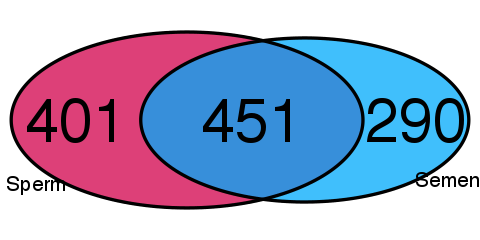

In [117]:
ejaculotome_candidates <- list(Semen = semen_min2Pep_MAGexpressed, Sperm = sperm_min2Pep_testesExpressed)

ejaculotome_Vdiag<-venn.diagram(ejaculotome_candidates, NULL, fill=c("#01aafb", "#d1004b"), alpha=c(0.75,0.75), cex = 3, cat.fontface= 6, cat.cex = 1, resolution = 100, )

options(repr.plot.width = 4, repr.plot.height = 2)
# pdf("~/Desktop/FIGURES/ejaculotome_Venn_min2Pep_4fold.pdf", width = 6, height = 3)
grid.arrange(gTree(children=ejaculotome_Vdiag))
# dev.off()

Let's also plot the mRNA expression levels for these genes. We'll set the ejaculotome factors to plot alongside the heatmap, but first we need to generate the elemental object:

In [118]:
ejaculotome_combs <- unlist(lapply(1:length(ejaculotome_candidates), function(j) combn(names(ejaculotome_candidates), j, simplify = FALSE)), recursive = FALSE)
names(ejaculotome_combs) <- sapply(ejaculotome_combs, function(i) paste0(i, collapse = ","))
ejaculotome_elements <- lapply(ejaculotome_combs, function(i) Setdiff(ejaculotome_candidates[i], ejaculotome_candidates[setdiff(names(ejaculotome_candidates), i)]))

Now make the factor data frame:

In [119]:
ejaculotome_factor_df = as.data.frame(unlist(ejaculotome_elements))
ejaculotome_factor_df$Classification = gsub('[[:digit:]]+', '', rownames(ejaculotome_factor_df))
ejaculotome_factor_df = as.data.frame(as.list(ejaculotome_factor_df))
rownames(ejaculotome_factor_df) = ejaculotome_factor_df$unlist.ejaculotome_elements.
ejaculotome_factor_df = subset(ejaculotome_factor_df, select = "Classification")

We'll extract a TPM matrix for the genes in the factor table:

In [120]:
ejaculotome.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% rownames(ejaculotome_factor_df))
ejaculotome.meanTPM = subset(ejaculotome.meanTPM, select = c("virMAG", "depMAG", "testes"))
ejaculotome.meanTPM = subset(ejaculotome.meanTPM, rowSums(ejaculotome.meanTPM) > 10)

Now generate the heatmap:

for plotting:: min.raw: -1 max.raw: 1


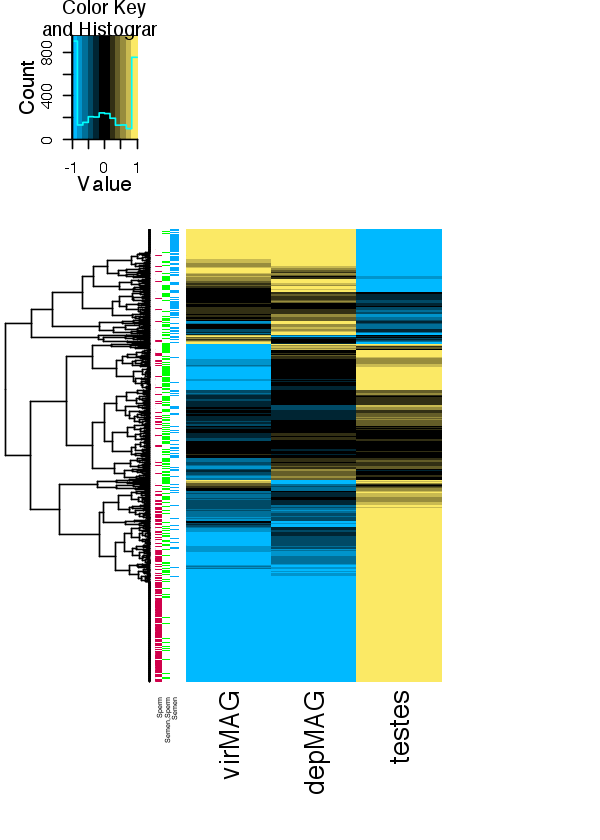

In [121]:
data = ejaculotome.meanTPM
gene_factors = unique(ejaculotome_factor_df[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(12, '#00b9ff', 'black','#fbe965')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(ejaculotome_factor_df[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#d1004b", "green","#01aafb")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

options(repr.plot.width = 5, repr.plot.height = 7)
# par(mfrow=c(1,2))
# pdf("~/Desktop/FIGURES/ejaculotome_heatmap1_min2Pep_4fold.pdf", width = 5, height = 7)
heatmap.3(heatmap_data, dendrogram = "row", col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=2, margins=c(10,10), labRow = F, sepwidth = 4, notecex = 20,keysize = 1.5, cex.main = 4)
# dev.off()

Here's an alternative way to make the heatmap... quality is better for publication.

In [122]:
# options(repr.plot.width = 5, repr.plot.height = 7)
# # pdf("~/Desktop/FIGURES/ejaculotome_heatmap2_min2Pep_4fold.pdf", width = 5, height = 7)
# heatmap3(heatmap_data,
#          col=myheatcol, 
#          cexCol = 1, 
# #          srtCol = 45,
#          labRow = "", 
# #          adjCol = c(1,0.1),
# #          legendfun=function() showLegend(legend=c("Sperm", "SFPs,Sperm", "SFPs"), 
# #                                          col=c("#ff9419","#9d93ff","#a10072"), 
# #                                          cex = 1), 
#             cex.main=0.4, 
#              RowSideColors = geneFactorAnnotations,
#              margins=c(10,20),
#              ColSideWidth = 5)
# dev.off()

Now we can run a GO analysis on those three classes of genes. First we need to swap out mstrg_IDs for gene_IDs. 

In [123]:
ejaculotome_factor_tmp = ejaculotome_factor_df
ejaculotome_factor_tmp$mstrg_ID = rownames(ejaculotome_factor_df)
tmpFile = subset(tmpDF, mstrg_ID %in% ejaculotome_factor_tmp$mstrg_ID)
tmpFile = subset(tmpFile, select = c("mstrg_ID", "gene_ID"))
ejaculotome_factor_df2 = unique(merge(ejaculotome_factor_tmp, tmpFile))
rownames(ejaculotome_factor_df2) = ejaculotome_factor_df2$gene_ID
ejaculotome_factor_df2 = subset(ejaculotome_factor_df2, select = "Classification")

Now set up the null object:

Warning message in pcls(G):
"initial point very close to some inequality constraints"

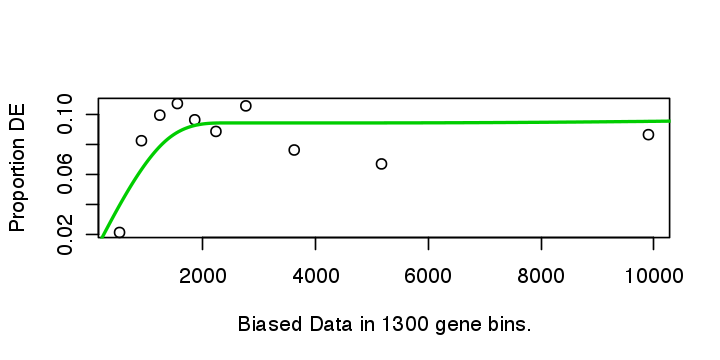

In [124]:
options(repr.plot.width = 6, repr.plot.height = 3)

cat_genes_vec = as.integer(features_with_GO %in% rownames(ejaculotome_factor_df2))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

output the enrichment result:

In [125]:
ejaculotome_factor_list = unique(ejaculotome_factor_df2[,1])

GO_enriched_list = list()

for (feature_cat in ejaculotome_factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(ejaculotome_factor_df2)[ejaculotome_factor_df2$Class == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: Sperm
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: Semen,Sperm
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: Semen
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


We can look at a bubble plot for a quick preview of the result. This plot can be messsy with a lot of text, so we'll select a subset of the GO terms for each ontology/sample:

Warning message:
"Removed 147 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."Warning message:
"Removed 6 rows containing missing values (geom_text_repel)."Warning message:
"Removed 17 rows containing missing values (geom_text_repel)."Warning message:
"Removed 2 rows containing missing values (geom_text_repel)."Warning message:
"Removed 55 rows containing missing values (geom_text_repel)."

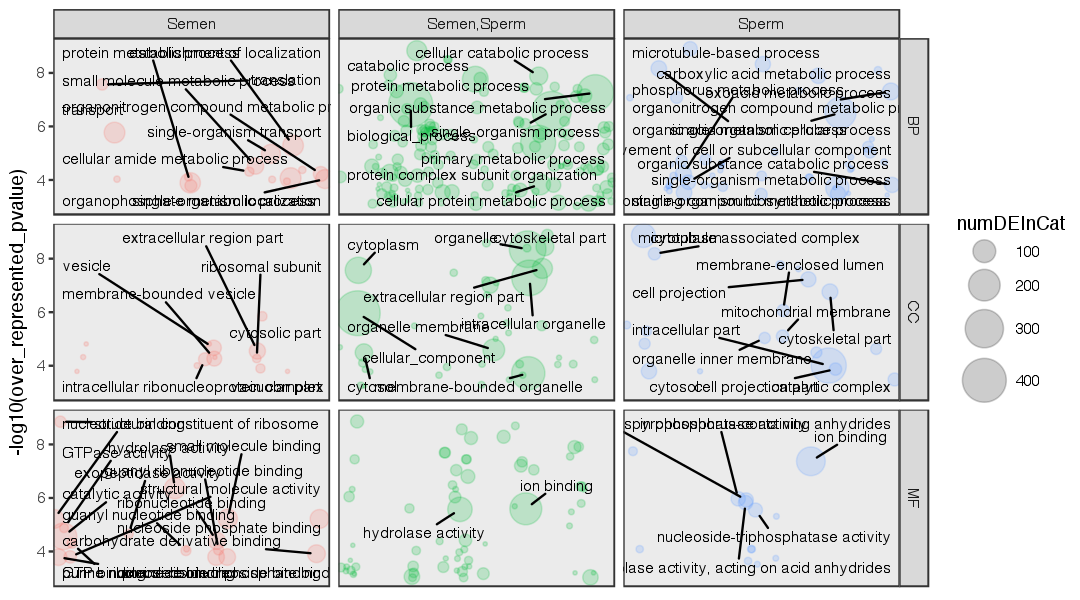

In [126]:
options(repr.plot.width = 9, repr.plot.height = 5)
# pdf("~/Desktop/FIGURES/GO_min2UnPep_2fold.pdf", width = 9, height = 7)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 ), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = factor)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~factor) +
    xlab(NULL) + 
geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "Sperm" & ontology == "BP" & numDEInCat > 30), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 100, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "Sperm" & ontology == "CC" & numDEInCat > 20), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 100, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "Sperm" & ontology == "MF" & numDEInCat > 30), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 150, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "Semen" & ontology == "MF" & numDEInCat > 10), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 100, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "Semen" & ontology == "BP" & numDEInCat > 10), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 100, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "Semen" & ontology == "CC" & numDEInCat > 10), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 100, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "Semen,Sperm" & numDEInCat > 50), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 100, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
#     scale_colour_manual(values=c("#d1004b", "#01aafb")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))
# dev.off()

Now append a column to the `ejaculotome_all` object describing the protein assignments for the ejaculotome (sperm, SFP, or both).

In [127]:
ejaculotome_assign = ejaculotome_all
ejaculotome_assign$Degner_classification = NULL
ejaculotome_assign$Degner_classification = ifelse(ejaculotome_assign$mstrg_ID %in% semen_min2Pep & ejaculotome_assign$mstrg_ID %in% sperm_min2Pep, "sperm and semen", ifelse(ejaculotome_assign$mstrg_ID %in% semen_min2Pep, "semen", ifelse(ejaculotome_assign$mstrg_ID %in% sperm_min2Pep, "sperm", "not classified")))

### Analysis of orthologous sperm proteomes:

In [128]:
rel.orthoDB = subset(orthoDB, select = c("Aedes.aegypti.gene.name", "Drosophila.melanogaster", "Manduca.sexta", "Apis.mellifera", "Mus.musculus"))

We'll need to disaggregate the _aegypti_ gene ID column first:

In [129]:
rel.orthoDB = rel.orthoDB %>% mutate(Aedes.aegypti.gene.name = strsplit(as.character(Aedes.aegypti.gene.name), ";")) %>% unnest(Aedes.aegypti.gene.name)
head(rel.orthoDB, n = 2)

Drosophila.melanogaster,Manduca.sexta,Apis.mellifera,Mus.musculus,Aedes.aegypti.gene.name
FBgn0053196,Msex2.09193,551170,NA,LOC5569942
FBgn0005666,Msex2.01810;Msex2.01810-RAA,409821,22138,LOC5573881


Load the _D. melanogaster_ sperm proteome and SFP data:

In [130]:
mel_sperm = read.csv("proteomics/Other_species_proteomes/DmSP-II.txt", header = T, sep = "\t")
head(mel_sperm, n = 2)
mel_SFPs = read.csv("proteomics/Other_species_proteomes/ACPlist.Findlay.20130301.txt", header = T, sep = "\t")
head(mel_SFPs, n = 2)

FBgn_ID,CG_ID,gene_description,gene_symbol,current_study_overlap,proteome_overlap
FBgn0001281,CG7931,janus B,janB,"Double (1,2)",Current Study and DmSPI
FBgn0029501,CG13580,Caldesmon-related protein,Crtp,"Double (1,2)",Current Study and DmSPI


Submitted_Name,FBgn_ID,Symbol
Acp24A4,FBgn0051779,Acp24A4
Acp26Aa,FBgn0002855,Acp26Aa


Now let's see which of our sperm protiens are also sperm proteins in _D. mel_:

In [131]:
aegypti_proteome_orthoDB = subset(rel.orthoDB, Aedes.aegypti.gene.name %in% ejaculotome_assign$loc_ID)

### -------- TO BE CONTINUED --------

## Chromosome distribution

We'll subset the gene features for annotated genes, get the mean coordinate value, and include only genes with a single coordinate value:

In [132]:
annot.features = unique(subset(gene.features, select = c("contig", "min", "max", "ref_gene_id", "gene_id")))
annot.features$mean_coord = (annot.features$max + annot.features$min)/2
annot.features = as.data.frame(subset(annot.features, grepl("AAEL", ref_gene_id)))
annot.features = setDT(annot.features)[, .SD[which.max(mean_coord)], by=ref_gene_id]

FIrst we'll calculate the total number of genes on the 3 major chromosomes:

In [133]:
TotalGeneNumber = as.data.frame(table(factor(subset(annot.features, !grepl("NIGP", annot.features$contig))$contig)))
colnames(TotalGeneNumber) = c("chromosome", "All genes")
total_genes = nrow(annot.features)
TotalGeneNumber$proportion = (TotalGeneNumber$`All genes`/total_genes)

Make several data frames with testes and MAG data for each category of tissue-biased genes and sperm/semen proteomes: 

In [134]:
genomeNumber.MAG.extreme = length(MAG.extreme.list.CDS)
chromNumber.MAG.extreme=as.data.frame(table(factor(subset(annot.features, gene_id %in% MAG.extreme.list.CDS & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.MAG.extreme) = c("chromosome", "Observed_biased_genes")
chromNumber.MAG.extreme$tissue = "MAGs"
chromNumber.MAG.extreme = merge(TotalGeneNumber, chromNumber.MAG.extreme)
chromNumber.MAG.extreme$`Expected genes` = genomeNumber.MAG.extreme*chromNumber.MAG.extreme$proportion
chromNumber.MAG.extreme$`obs.exp` = chromNumber.MAG.extreme$Observed_biased_genes/chromNumber.MAG.extreme$`Expected genes`
chromNumber.MAG.extreme$gene_class = "4-fold"

In [135]:
genomeNumber.MAG.DEup = length(MAG.DEup.list.CDS)
chromNumber.MAG.DEup=as.data.frame(table(factor(subset(annot.features, gene_id %in% MAG.DEup.list.CDS & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.MAG.DEup) = c("chromosome", "Observed_biased_genes")
chromNumber.MAG.DEup$tissue = "MAGs"
chromNumber.MAG.DEup = merge(TotalGeneNumber, chromNumber.MAG.DEup)
chromNumber.MAG.DEup$`Expected genes` = genomeNumber.MAG.DEup*chromNumber.MAG.DEup$proportion
chromNumber.MAG.DEup$`obs.exp` = chromNumber.MAG.DEup$Observed_biased_genes/chromNumber.MAG.DEup$`Expected genes`
chromNumber.MAG.DEup$gene_class = "2-fold"

In [136]:
genomeNumber.MAG.up = length(MAG.up.list.CDS)
chromNumber.MAG.up=as.data.frame(table(factor(subset(annot.features, gene_id %in% MAG.up.list.CDS & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.MAG.up) = c("chromosome", "Observed_biased_genes")
chromNumber.MAG.up$tissue = "MAGs"
chromNumber.MAG.up = merge(TotalGeneNumber, chromNumber.MAG.up)
chromNumber.MAG.up$`Expected genes` = genomeNumber.MAG.up*chromNumber.MAG.up$proportion
chromNumber.MAG.up$`obs.exp` = chromNumber.MAG.up$Observed_biased_genes/chromNumber.MAG.up$`Expected genes`
chromNumber.MAG.up$gene_class = "1-fold"

In [137]:
genomeNumber.MAG.expressed = length(MAG.expressed.list.CDS)
chromNumber.MAG.expressed=as.data.frame(table(factor(subset(annot.features, gene_id %in% MAG.expressed.list.CDS & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.MAG.expressed) = c("chromosome", "Observed_biased_genes")
chromNumber.MAG.expressed$tissue = "MAGs"
chromNumber.MAG.expressed = merge(TotalGeneNumber, chromNumber.MAG.expressed)
chromNumber.MAG.expressed$`Expected genes` = genomeNumber.MAG.expressed*chromNumber.MAG.expressed$proportion
chromNumber.MAG.expressed$`obs.exp` = chromNumber.MAG.expressed$Observed_biased_genes/chromNumber.MAG.expressed$`Expected genes`
chromNumber.MAG.expressed$gene_class = "expressed"

In [138]:
genomeNumber.SFPs = length(semen_min2Pep_MAGexpressed)
chromNumber.SFPs=as.data.frame(table(factor(subset(annot.features, gene_id %in% semen_min2Pep_MAGexpressed & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.SFPs) = c("chromosome", "Observed_biased_genes")
chromNumber.SFPs$tissue = "MAGs"
chromNumber.SFPs = merge(TotalGeneNumber, chromNumber.SFPs)
chromNumber.SFPs$`Expected genes` = genomeNumber.SFPs*chromNumber.SFPs$proportion
chromNumber.SFPs$`obs.exp` = chromNumber.SFPs$Observed_biased_genes/chromNumber.SFPs$`Expected genes`
chromNumber.SFPs$gene_class = "proteome"

Now for testes:

In [139]:
genomeNumber.testes.extreme = length(testes.extreme.list.CDS)
chromNumber.testes.extreme=as.data.frame(table(factor(subset(annot.features, gene_id %in% testes.extreme.list & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.testes.extreme) = c("chromosome", "Observed_biased_genes")
chromNumber.testes.extreme$tissue = "Testes"
chromNumber.testes.extreme = merge(TotalGeneNumber, chromNumber.testes.extreme)
chromNumber.testes.extreme$`Expected genes` = genomeNumber.testes.extreme*chromNumber.testes.extreme$proportion
chromNumber.testes.extreme$`obs.exp` = chromNumber.testes.extreme$Observed_biased_genes/chromNumber.testes.extreme$`Expected genes`
chromNumber.testes.extreme$gene_class = "4-fold"

In [140]:
genomeNumber.testes.DEup = length(testes.DEup.list.CDS)
chromNumber.testes.DEup=as.data.frame(table(factor(subset(annot.features, gene_id %in% testes.DEup.list & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.testes.DEup) = c("chromosome", "Observed_biased_genes")
chromNumber.testes.DEup$tissue = "Testes"
chromNumber.testes.DEup = merge(TotalGeneNumber, chromNumber.testes.DEup)
chromNumber.testes.DEup$`Expected genes` = genomeNumber.testes.DEup*chromNumber.testes.DEup$proportion
chromNumber.testes.DEup$`obs.exp` = chromNumber.testes.DEup$Observed_biased_genes/chromNumber.testes.DEup$`Expected genes`
chromNumber.testes.DEup$gene_class = "2-fold"

In [141]:
genomeNumber.testes.up = length(testes.up.list.CDS)
chromNumber.testes.up=as.data.frame(table(factor(subset(annot.features, gene_id %in% testes.up.list & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.testes.up) = c("chromosome", "Observed_biased_genes")
chromNumber.testes.up$tissue = "Testes"
chromNumber.testes.up = merge(TotalGeneNumber, chromNumber.testes.up)
chromNumber.testes.up$`Expected genes` = genomeNumber.testes.up*chromNumber.testes.up$proportion
chromNumber.testes.up$`obs.exp` = chromNumber.testes.up$Observed_biased_genes/chromNumber.testes.up$`Expected genes`
chromNumber.testes.up$gene_class = "1-fold"

In [142]:
genomeNumber.testes.expressed = length(testes.expressed.list.CDS)
chromNumber.testes.expressed=as.data.frame(table(factor(subset(annot.features, gene_id %in% testes.expressed.list & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.testes.expressed) = c("chromosome", "Observed_biased_genes")
chromNumber.testes.expressed$tissue = "Testes"
chromNumber.testes.expressed = merge(TotalGeneNumber, chromNumber.testes.expressed)
chromNumber.testes.expressed$`Expected genes` = genomeNumber.testes.expressed*chromNumber.testes.expressed$proportion
chromNumber.testes.expressed$`obs.exp` = chromNumber.testes.expressed$Observed_biased_genes/chromNumber.testes.expressed$`Expected genes`
chromNumber.testes.expressed$gene_class = "expressed"

In [143]:
genomeNumber.sperm = length(sperm_min2Pep_testesExpressed)
chromNumber.sperm=as.data.frame(table(factor(subset(annot.features, gene_id %in% sperm_min2Pep_testesExpressed & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.sperm) = c("chromosome", "Observed_biased_genes")
chromNumber.sperm$tissue = "Testes"
chromNumber.sperm = merge(TotalGeneNumber, chromNumber.sperm)
chromNumber.sperm$`Expected genes` = genomeNumber.sperm*chromNumber.sperm$proportion
chromNumber.sperm$`obs.exp` = chromNumber.sperm$Observed_biased_genes/chromNumber.sperm$`Expected genes`
chromNumber.sperm$gene_class = "proteome"

Then combine them:

In [144]:
tissue_biased.numbers = rbind(chromNumber.MAG.extreme, chromNumber.MAG.DEup, chromNumber.MAG.up, chromNumber.MAG.expressed, chromNumber.testes.extreme, chromNumber.testes.DEup, chromNumber.testes.up, chromNumber.testes.expressed, chromNumber.sperm, chromNumber.SFPs)
tissue_biased.numbers$gene_class = factor(tissue_biased.numbers$gene_class, levels = c("proteome", "expressed", "1-fold", "2-fold", "4-fold"))
head(tissue_biased.numbers, n = 3)

chromosome,All genes,proportion,Observed_biased_genes,tissue,Expected genes,obs.exp,gene_class
1,4429,0.2246855,108,MAGs,67.18096,1.607598,4-fold
2,7168,0.3636364,111,MAGs,108.72727,1.020903,4-fold
3,6484,0.3289367,112,MAGs,98.35207,1.138766,4-fold


A barplot to visualize the results:

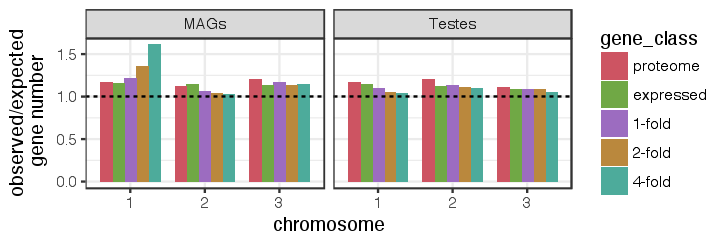

In [145]:
options(repr.plot.width = 6, repr.plot.height = 2)
# pdf("Figures/chromosome.pdf", width = 6, height = 2)
ggplot(subset(tissue_biased.numbers, chromosome != "MT"), aes(chromosome, obs.exp, fill = gene_class)) +
    facet_wrap(~tissue) +
    geom_bar(position=position_dodge(), stat="identity", width = 0.8) +
    geom_hline(yintercept = 1, linetype = "dashed") +
    scale_fill_manual(values = c("#cd5462","#70a845","#9c6cc0","#ba883d","#4dab9b")) +
    ylab("observed/expected\n gene number") +
    theme_bw()
# dev.off()

We can look at proportion of gene categoris across different genomic windows. First we'll make a gene-based coordiantes table:

In [146]:
coords = subset(gene.features, !is.na(ref_gene_id))
coords = unique(subset(coords, select = c("contig", "min", "gene_id")))
coords <- aggregate(min~gene_id+contig, coords, min)

Then we'll output a table of gene numbers by genomic window:

In [147]:
# subset each chromosome separately
coords_1 = subset(coords, contig == 1)
coords_2 = subset(coords, contig == 2)
coords_3 = subset(coords, contig == 3)

# set the number of bins for each chromosome
bin_1 <- seq(1,max(coords_1$min),1000000)
bin_2 <- seq(1,max(coords_2$min),1000000)
bin_3 <- seq(1,max(coords_3$min),1000000)

# initiate an empty object for each gene class and each chromosome:
testes_1 = NULL
testes_2 = NULL
testes_3 = NULL
MAG_1 = NULL
MAG_2 = NULL
MAG_3 = NULL
all_1 = NULL
all_2 = NULL
all_3 = NULL

# loop over each bin and count the number of each gene class
# Chr 1
for (i in 1:length(bin_1)) { 
        testes_1[i] = nrow(subset(coords_1, gene_id %in% testes.extreme.list.CDS & min > bin_1[i] & min < bin_1[i+1]))
        MAG_1[i] = nrow(subset(coords_1, gene_id %in% MAG.extreme.list.CDS & min > bin_1[i] & min < bin_1[i+1]))
        all_1[i] = nrow(subset(coords_1, min > bin_1[i] & min < bin_1[i+1]))
    }
# Chr 2
for (i in 1:length(bin_2)) { 
        testes_2[i] = nrow(subset(coords_2, gene_id %in% testes.extreme.list.CDS & min > bin_2[i] & min < bin_2[i+2]))
        MAG_2[i] = nrow(subset(coords_2, gene_id %in% MAG.extreme.list.CDS & min > bin_2[i] & min < bin_2[i+2]))
        all_2[i] = nrow(subset(coords_2, min > bin_2[i] & min < bin_2[i+2]))
    }
# Chr 3
for (i in 1:length(bin_3)) { 
        testes_3[i] = nrow(subset(coords_3, gene_id %in% testes.extreme.list.CDS & min > bin_3[i] & min < bin_3[i+3]))
        MAG_3[i] = nrow(subset(coords_3, gene_id %in% MAG.extreme.list.CDS & min > bin_3[i] & min < bin_3[i+3]))
        all_3[i] = nrow(subset(coords_3, min > bin_3[i] & min < bin_3[i+3]))
    }

# Combine the output above for each gene class by chromosome, then merge all data for each chromosome
biasDF_1 = data.frame(window = bin_1, chromosome = "Chr_1", testes = testes_1, MAG = MAG_1, all = all_1)
biasDF_2 = data.frame(window = bin_2, chromosome = "Chr_2", testes = testes_2, MAG = MAG_2, all = all_2)
biasDF_3 = data.frame(window = bin_3, chromosome = "Chr_3", testes = testes_3, MAG = MAG_3, all = all_3)
biasDF = rbind(biasDF_1, biasDF_2, biasDF_3)

We'll calculate the proportion of each gene class for each window

In [148]:
biasDF$testes_prop = biasDF$testes/biasDF$all
biasDF$MAG_prop = biasDF$MAG/biasDF$all
biasDF$all_prop = biasDF$all/sum(biasDF$all)
head(biasDF)

window,chromosome,testes,MAG,all,testes_prop,MAG_prop,all_prop
1,Chr_1,3,0,30,0.10000000,0,8.188667e-04
1000001,Chr_1,1,0,13,0.07692308,0,3.548422e-04
2000001,Chr_1,0,0,2,0.00000000,0,5.459111e-05
3000001,Chr_1,2,0,29,0.06896552,0,7.915711e-04
4000001,Chr_1,0,0,6,0.00000000,0,1.637733e-04
5000001,Chr_1,1,0,9,0.11111111,0,2.456600e-04


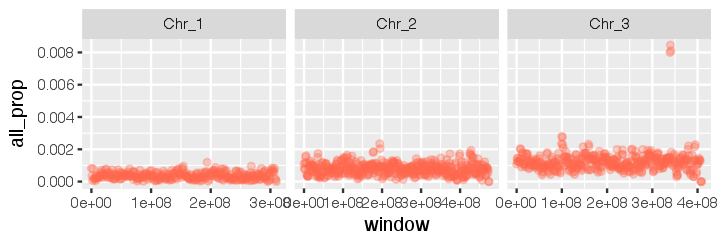

In [149]:
ggplot(biasDF) + 
    geom_point(mapping = aes(window, all_prop), alpha = 0.3, colour = "#ff674f") +
    facet_wrap(~chromosome,  scales = "free_x")

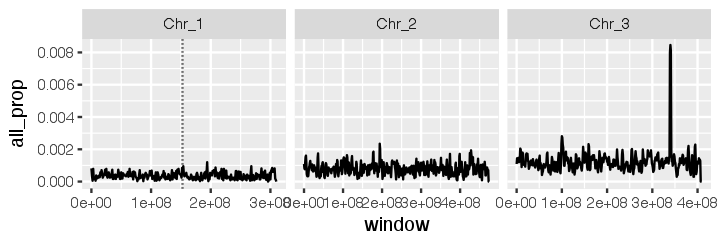

In [150]:
ggplot(biasDF, aes(window, all_prop)) + 
    geom_line() + 
    facet_wrap(~chromosome, scales = "free_x") +
    geom_vline(data=data.frame(xint=152616641,chromosome="Chr_1"),aes(xintercept=xint),linetype="dotted")

### -------- TO BE CONTINUED --------

## Popgen results:

In [151]:
popgenALL = read.table("popgen_results/PopGen.whole.CDS.result.withGeneID.txt", header = T, sep = "\t")
popgenSyn = read.table("popgen_results/PopGen.Syn.sites.result.withGeneIDtxt", header = T, sep = "\t")
popgenNon = read.table("popgen_results/PopGen.nonSyn.sites.result.withGeneIDtxt", header = T, sep = "\t")
colnames(popgenALL) = c('ref_gene_id', 'TRANSCRIPT', 'pi_all', 'theta_all', 'Tajimas_D_all', 'Fu_and_Li_F_all', 'Fu_and_Li_D_all', 'segSites_all')
colnames(popgenSyn) = c('ref_gene_id', 'TRANSCRIPT', 'pi_syn', 'theta_syn', 'Tajimas_D_syn', 'Fu_and_Li_F_syn', 'Fu_and_Li_D_syn', 'segSites_syn')
colnames(popgenNon) = c('ref_gene_id', 'TRANSCRIPT', 'pi_non', 'theta_non', 'Tajimas_D_non', 'Fu_and_Li_F_non', 'Fu_and_Li_D_non', 'segSites_non')

In [152]:
someTmp = merge(popgenALL, popgenSyn, by.x = "TRANSCRIPT", by.y = "TRANSCRIPT", all =T)
popGen.agg = merge(someTmp, popgenNon, by.x = "TRANSCRIPT", by.y = "TRANSCRIPT", all =T)
nrow(popGen.agg)
head(popGen.agg)

[1] 16734

TRANSCRIPT,ref_gene_id.x,pi_all,theta_all,Tajimas_D_all,Fu_and_Li_F_all,Fu_and_Li_D_all,segSites_all,ref_gene_id.y,pi_syn,⋯,Fu_and_Li_F_syn,Fu_and_Li_D_syn,segSites_syn,ref_gene_id,pi_non,theta_non,Tajimas_D_non,Fu_and_Li_F_non,Fu_and_Li_D_non,segSites_non
AAEL000001-RA,AAEL000001,15.20258,16.67692,-0.7407771,1.2445406,2.107894,87,AAEL000001,12.734503,⋯,1.327261,2.057626,67,AAEL000001,2.468073,3.833774,-1.4021700,0.72954995,1.6903566,20
AAEL000002-RA,AAEL000002,18.47573,11.30963,1.4378775,2.1622327,2.029611,59,AAEL000002,7.082898,⋯,1.746964,1.774605,25,AAEL000002,11.392830,6.517416,1.7193334,2.16954282,1.8791517,34
AAEL000003-RA,AAEL000003,44.12216,31.05357,0.8259661,2.0032632,2.193707,162,AAEL000003,37.034986,⋯,2.138466,2.164116,126,AAEL000003,7.087174,6.900794,-0.3708239,1.28484470,1.8969900,36
AAEL000004-RA,AAEL000004,12.99832,12.84314,-0.4298132,1.1503149,1.785410,67,AAEL000004,10.841673,⋯,1.315923,1.821167,51,AAEL000004,2.156647,3.067019,-1.2025974,0.41408053,1.1569467,16
AAEL000005-RB,AAEL000005,9.90758,11.11795,-0.7895077,0.9444474,1.716089,58,AAEL000005,7.774272,⋯,1.207141,1.949136,43,AAEL000005,2.133308,2.875331,-1.0888287,0.06355665,0.6435605,15
AAEL000005-RC,AAEL000005,10.94548,12.65146,-0.8727695,0.9493351,1.778526,66,AAEL000005,8.231889,⋯,1.159611,1.978901,48,AAEL000005,2.713592,3.450397,-0.9968536,0.24164216,0.8366930,18


In [153]:
TajData = subset(popGen.agg, select = c("TRANSCRIPT", "ref_gene_id.x", "Tajimas_D_all", "Tajimas_D_syn", "Tajimas_D_non"))
TajData = melt(TajData, id.vars = c("TRANSCRIPT", "ref_gene_id.x"))
colnames(TajData) = c("transcript_id", "ref_gene_id", "source", "Tajima's D")
TajData$`Site class` = ifelse(TajData$source == "Tajimas_D_all", "All", ifelse(TajData$source == "Tajimas_D_syn", "Synonymous", "Nonsynonymous"))
head(TajData)

transcript_id,ref_gene_id,source,Tajima's D,Site class
AAEL000001-RA,AAEL000001,Tajimas_D_all,-0.7407771,All
AAEL000002-RA,AAEL000002,Tajimas_D_all,1.4378775,All
AAEL000003-RA,AAEL000003,Tajimas_D_all,0.8259661,All
AAEL000004-RA,AAEL000004,Tajimas_D_all,-0.4298132,All
AAEL000005-RB,AAEL000005,Tajimas_D_all,-0.7895077,All
AAEL000005-RC,AAEL000005,Tajimas_D_all,-0.8727695,All


Warning message:
"Removed 724 rows containing non-finite values (stat_density)."

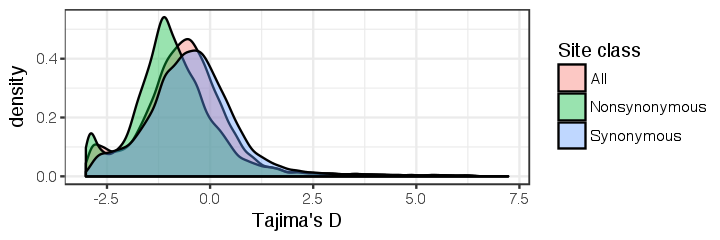

In [154]:
# pdf("Figures/ejaculotome_heatmap.pdf", width = 5, height = 4)
ggplot(TajData, aes(`Tajima's D`, fill = `Site class`)) + 
    geom_density(alpha = 0.4) +
    theme_bw()
# dev.off()

In [155]:
subTajData = subset(TajData, ref_gene_id %in% ejaculotome_assign$gene_ID)
tmpData = merge(ejaculotome_assign, subTajData, by.x = "gene_ID", by.y = "ref_gene_id")
nrow(tmpData)
head(tmpData)

[1] 4488

gene_ID,mstrg_ID,loc_ID,gene_name,protein,protein.name,sperm.combined.full,sperm.tandem.full,sperm.comet.full,sperm.union.full,⋯,signalP,semen_MAX.total_peptides,semen_MAX.unique_peptides,sperm_MAX.total_peptides,sperm_MAX.unique_peptides,Degner_classification,transcript_id,source,Tajima's D,Site class
AAEL000004,MSTRG.24859,LOC5563659,NA,XP_001647883.2,GPI mannosyltransferase 3,0,1,1,1,⋯,YES,0,0,2,1,not classified,AAEL000004-RA,Tajimas_D_syn,-0.1353773,Synonymous
AAEL000004,MSTRG.24859,LOC5563659,NA,XP_001647883.2,GPI mannosyltransferase 3,0,1,1,1,⋯,YES,0,0,2,1,not classified,AAEL000004-RA,Tajimas_D_all,-0.4298132,All
AAEL000004,MSTRG.24859,LOC5563659,NA,XP_001647883.2,GPI mannosyltransferase 3,0,1,1,1,⋯,YES,0,0,2,1,not classified,AAEL000004-RA,Tajimas_D_non,-1.2025974,Nonsynonymous
AAEL000006,MSTRG.24787,LOC5563591,NA,XP_001647935.2,phosphoenolpyruvate carboxykinase [GTP],0,0,0,0,⋯,NO,27,11,0,0,semen,AAEL000006-RA,Tajimas_D_all,-0.7160139,All
AAEL000006,MSTRG.24787,LOC5563591,NA,XP_001647935.2,phosphoenolpyruvate carboxykinase [GTP],0,0,0,0,⋯,NO,27,11,0,0,semen,AAEL000006-RB,Tajimas_D_syn,-0.3697677,Synonymous
AAEL000006,MSTRG.24787,LOC5563591,NA,XP_001647935.2,phosphoenolpyruvate carboxykinase [GTP],0,0,0,0,⋯,NO,27,11,0,0,semen,AAEL000006-RC,Tajimas_D_syn,-0.6307476,Synonymous


Warning message:
"Removed 86 rows containing non-finite values (stat_boxplot)."

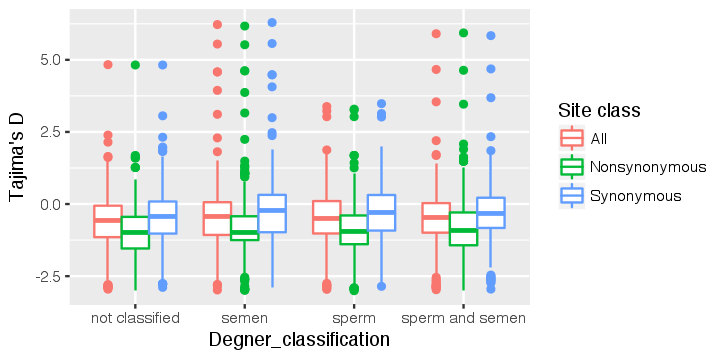

In [156]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(tmpData, aes(Degner_classification, `Tajima's D`, colour = `Site class`)) + geom_boxplot() 

We also have some McDonal-Kreitman result with _Ae. formosus_ as the outgroup:

In [157]:
mkData = read.table("popgen_results/proteome.MK.results.withGeneID.txt", header = T, sep = "\t")

In [158]:
mkData$NS = mkData$NS_POLY + mkData$NS_FIX
mkData$S = mkData$S_POLY + mkData$S_FIX
mkData$propNS = mkData$NS /(mkData$NS + mkData$S)
head(mkData)

gene,TRANSCRIPT,NS_POLY,S_POLY,NS_FIX,S_FIX,codons,final_NI,alpha,final_FET,NS,S,propNS
AAEL000003,AAEL000003-RA.fa,7,63,1,16,655,1.7778,-0.7778,1.0000,8,79,0.09195402
AAEL000004,AAEL000004-RA.fa,9,20,0,4,512,0.0000,1.0000,0.5548,9,24,0.27272727
AAEL000006,AAEL000006-RA.fa,7,39,0,3,617,0.0000,1.0000,1.0000,7,42,0.14285714
AAEL000006,AAEL000006-RB.fa,8,40,0,0,616,0.0000,1.0000,1.0000,8,40,0.16666667
AAEL000006,AAEL000006-RC.fa,3,22,1,9,613,1.2273,-0.2273,1.0000,4,31,0.11428571
AAEL000010,AAEL000010-RA.fa,0,1,0,0,109,0.0000,1.0000,1.0000,0,1,0.00000000


### -------- TO BE CONTINUED --------

# SUPPLEMENTARY MATERIAL:

## Proteomics QC:

Three search algorithms ("combined", Tandem, anc Comet) were used to query the MS spectra against the full aegypti transcriptome. In the `proteome_data` object, these are specified by columns as 0/1 entries. First we'll check the overlap of protein IDs across the three search algorithms.

First the sperm samples:

In [159]:
sperm.combined.full = subset(proteome_data, sperm.combined.full == 1)$gene
sperm.tandem.full = subset(proteome_data, sperm.tandem.full == 1)$gene
sperm.comet.full = subset(proteome_data, sperm.comet.full == 1)$gene

and semen samples:

In [160]:
semen.combined.full = subset(proteome_data, semen.combined.full == 1)$gene
semen.tandem.full = subset(proteome_data, semen.tandem.full == 1)$gene
semen.comet.full = subset(proteome_data, semen.comet.full == 1)$gene

We'll also extract the gene IDs used for expression analysis:

In [161]:
# first from the Sirot dataset
sirot_SFPs_mstrg = unique(subset(proteome_IDs, loc_ID %in% sirot_SFPs & !is.na(mstrg_ID))$mstrg_ID)
sirot_Sps_mstrg = unique(subset(proteome_IDs, loc_ID %in% sirot_Sps & !is.na(mstrg_ID))$mstrg_ID)

# ...and for the sperm samples for all three algorithms
sperm.combined.full_mstrg = unique(subset(proteome_IDs, loc_ID %in% sperm.combined.full & !is.na(mstrg_ID))$mstrg_ID)
sperm.tandem.full_mstrg = unique(subset(proteome_IDs, loc_ID %in% sperm.tandem.full & !is.na(mstrg_ID))$mstrg_ID)
sperm.comet.full_mstrg = unique(subset(proteome_IDs, loc_ID %in% sperm.comet.full & !is.na(mstrg_ID))$mstrg_ID)

# ...and for the semen samples for all three algorithms
semen.combined.full_mstrg = unique(subset(proteome_IDs, loc_ID %in% semen.combined.full & !is.na(mstrg_ID))$mstrg_ID)
semen.tandem.full_mstrg = unique(subset(proteome_IDs, loc_ID %in% semen.tandem.full & !is.na(mstrg_ID))$mstrg_ID)
semen.comet.full_mstrg = unique(subset(proteome_IDs, loc_ID %in% semen.comet.full & !is.na(mstrg_ID))$mstrg_ID)

The best way to compare the content of these is to make Venn diagrmas. First we'll need to distribute the individual lists into larger lists for sperm and semen proteins separately.

First for sperm proteins:

In [162]:
sperm_candidates <- list(combined = sperm.combined.full, tandem = sperm.tandem.full, comet = sperm.comet.full, sirot = sirot_Sps)

sperm_combs <- unlist(lapply(1:length(sperm_candidates), function(j) combn(names(sperm_candidates), j, simplify = FALSE)), recursive = FALSE)
    
names(sperm_combs) <- sapply(sperm_combs, function(i) paste0(i, collapse = ","))
    
sperm_elements <- lapply(sperm_combs, function(i) Setdiff(sperm_candidates[i], sperm_candidates[setdiff(names(sperm_candidates), i)]))
    
sperm_Vdiag<-venn.diagram(sperm_candidates, NULL, fill=c("#8d2878","#95d864","#ff3ea8", "gray"), alpha=c(0.75, 0.75,0.75, 0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "sperm proteome")

... and for semen proteins:

In [163]:
semen_candidates <- list(combined = semen.combined.full, tandem = semen.tandem.full, comet = semen.comet.full, sirot = sirot_SFPs)

semen_combs <- unlist(lapply(1:length(semen_candidates), function(j) combn(names(semen_candidates), j, simplify = FALSE)), recursive = FALSE)
    
names(semen_combs) <- sapply(semen_combs, function(i) paste0(i, collapse = ","))
    
semen_elements <- lapply(semen_combs, function(i) Setdiff(semen_candidates[i], semen_candidates[setdiff(names(semen_candidates), i)]))
    
semen_Vdiag<-venn.diagram(semen_candidates, NULL, fill=c("#8d2878","#95d864","#ff3ea8", "gray"), alpha=c(0.75, 0.75,0.75, 0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "semen proteome")

Now we can plot the two venn diagrams for sperm and semen:

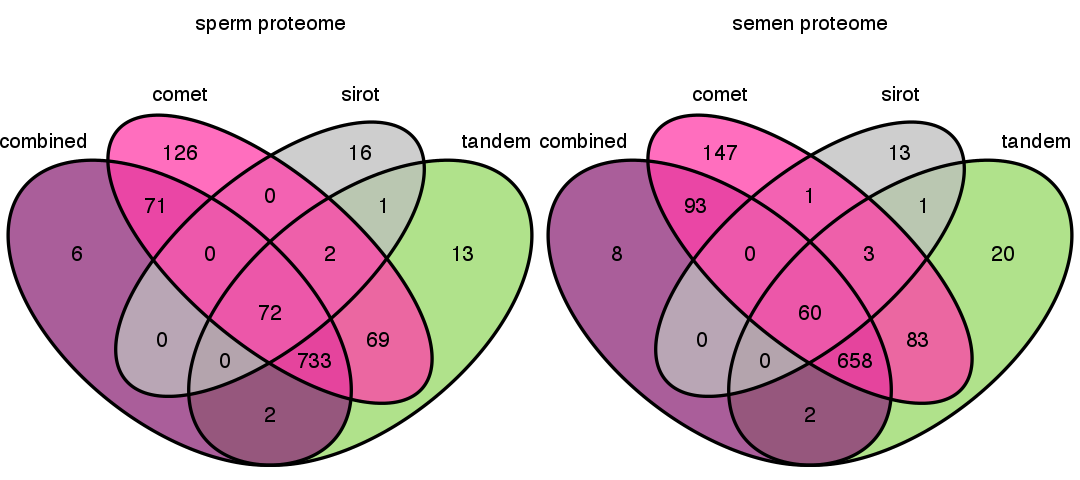

In [164]:
options(repr.plot.width = 9, repr.plot.height = 4)
grid.arrange(gTree(children=sperm_Vdiag), gTree(children=semen_Vdiag), ncol = 2)

Lets do the same for MSTRG Id's, but remove Sirot data, so we can look at mRNA expressions profile:

In [165]:
sperm_candidates_mstrg <- list(combined = sperm.combined.full_mstrg, tandem = sperm.tandem.full_mstrg, comet = sperm.comet.full_mstrg)

sperm_combs_mstrg <- unlist(lapply(1:length(sperm_candidates_mstrg), function(j) combn(names(sperm_candidates_mstrg), j, simplify = FALSE)), recursive = FALSE)
    
names(sperm_combs_mstrg) <- sapply(sperm_combs_mstrg, function(i) paste0(i, collapse = ","))
    
sperm_elements_mstrg <- lapply(sperm_combs_mstrg, function(i) Setdiff(sperm_candidates_mstrg[i], sperm_candidates_mstrg[setdiff(names(sperm_candidates_mstrg), i)]))
    
sperm_Vdiag_mstrg<-venn.diagram(sperm_candidates_mstrg, NULL, fill=c("#b8c80c","#5c3ea8","#d3003b"), alpha=c(0.75,0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "sperm proteome") 

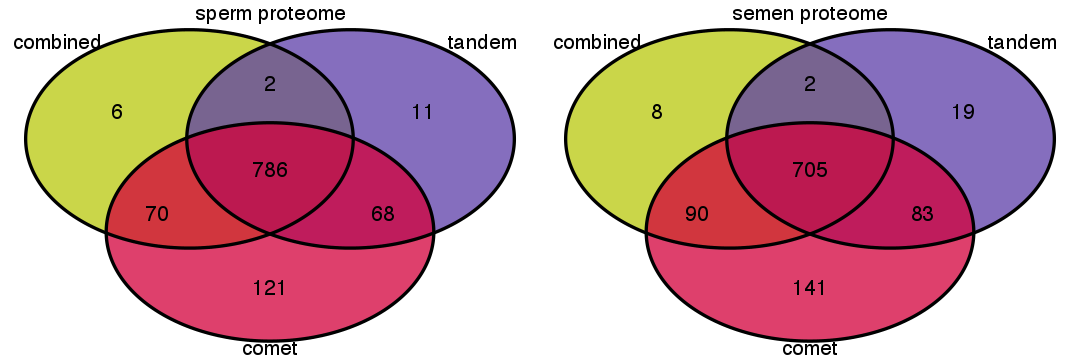

In [166]:
semen_candidates_mstrg <- list(combined = semen.combined.full_mstrg, tandem = semen.tandem.full_mstrg, comet = semen.comet.full_mstrg)
semen_combs_mstrg <- unlist(lapply(1:length(semen_candidates_mstrg), function(j) combn(names(semen_candidates_mstrg), j, simplify = FALSE)), recursive = FALSE)
names(semen_combs_mstrg) <- sapply(semen_combs_mstrg, function(i) paste0(i, collapse = ","))
semen_elements_mstrg <- lapply(semen_combs_mstrg, function(i) Setdiff(semen_candidates_mstrg[i], semen_candidates_mstrg[setdiff(names(semen_candidates_mstrg), i)]))
semen_Vdiag_mstrg<-venn.diagram(semen_candidates_mstrg, NULL, fill=c("#b8c80c","#5c3ea8","#d3003b"), alpha=c(0.75,0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "semen proteome")
    
options(repr.plot.width = 9, repr.plot.height = 3)
grid.arrange(gTree(children=sperm_Vdiag_mstrg), gTree(children=semen_Vdiag_mstrg), ncol = 2)

Now let's look at the overlap between union of sperm and semen proteins against the full genome search:

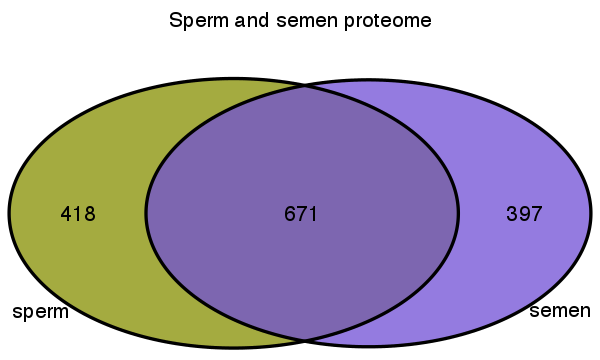

In [167]:
semen.union.full = subset(proteome_data, semen.union.full == 1)$gene
sperm.union.full = subset(proteome_data, sperm.union.full == 1)$gene

ejaculotome <- list(semen = semen.union.full, sperm = sperm.union.full)
ejaculotome_combs <- unlist(lapply(1:length(ejaculotome), function(j) combn(names(ejaculotome), j, simplify = FALSE)), recursive = FALSE)
names(ejaculotome_combs) <- sapply(ejaculotome_combs, function(i) paste0(i, collapse = ","))
ejaculotome_elements <- lapply(ejaculotome_combs, function(i) Setdiff(ejaculotome[i], ejaculotome[setdiff(names(ejaculotome), i)]))
ejaculotome_Vdiag<-venn.diagram(ejaculotome, NULL, fill=c("#704fd6","#868f00"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "Sperm and semen proteome")
    
options(repr.plot.width = 5, repr.plot.height = 3)
grid.arrange(gTree(children=ejaculotome_Vdiag))